# Gradient Matching Attack on a TF Classifier

In this notebook, we will learn how to use ART to run a clean-label gradient matching poisoning attack on a neural network trained with Tensorflow. We will be training our data on a subset of the CIFAR-10 dataset. The methods described are derived from [this paper](https://arxiv.org/abs/2009.02276) by Geiping, et. al. 2020.

## Train a model to attack

In this example, we use a RESNET50 model on the CIFAR dataset.

In [1]:
import numpy as np
import os, sys


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

from art.estimators.classification import TensorFlowV2Classifier
from art.utils import load_cifar10

(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()
# x_train = x_train[0:10000]
# y_train = y_train[0:10000]
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

min_ = (min_-mean)/(std+1e-7)
max_ = (max_-mean)/(std+1e-7)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# def create_model(x_train, y_train, num_classes=10, batch_size=64, epochs=100):
#     model = Sequential([
#         tf.keras.applications.ResNet50(input_shape=x_train.shape[1:], include_top=False, weights=None),
#         Flatten(),
#         Dense(num_classes, activation='softmax')
#     ])

#     model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

#     datagen = ImageDataGenerator(
#         featurewise_center=False,
#         samplewise_center=False,
#         featurewise_std_normalization=False,
#         samplewise_std_normalization=False,
#         zca_whitening=False,
#         rotation_range=15,
#         width_shift_range=0.1,
#         height_shift_range=0.1,
#         horizontal_flip=True,
#         vertical_flip=False
#         )
#     datagen.fit(x_train)
#     model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), steps_per_epoch=x_train.shape[0] // batch_size,epochs=epochs,verbose=1)
#     return model

# # model = create_model(x_train, y_train, epochs=150)
# model_art = TensorFlowV2Classifier(model, nb_classes=10, input_shape=model.input_shape)

In [ ]:
# Save the model
model.save('sleeper_agent_model_100_epochs')

# Load saved model

In [2]:
# The accuracy of saved model is ~81%
model = tf.keras.models.load_model('sleeper_agent_model_100_epochs')
model_art = TensorFlowV2Classifier(model, nb_classes=10, input_shape=model.input_shape)

## Choose Target Image from Test Set

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(80, 80, 3)


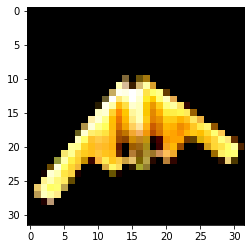

In [3]:
from tensorflow.keras.utils import to_categorical
from PIL import Image
from numpy import asarray
import matplotlib.pyplot as plt
from skimage.transform import resize

# # A trigger from class 0 will be classified into class 1.
class_source = 0
class_target = 1
# Select a random example for target
index_target = np.where(y_test.argmax(axis=1)==class_source)[0][5]

img = Image.open('trigger_10.png')

# PIL images into NumPy arrays
numpydata = asarray(img)
print(numpydata.shape)
p = resize(numpydata, (8,8,3))
# print(numpydata.shape)
  

# Trigger sample
# We can select any random trigger as per the paper
x_trigger = x_test[index_target:index_target+1]
# Will the position of tigger matter?????????????? RESEARCH QUESTIONS [Need to make this random]
# x_trigger[:,16:24,16:24,:] = p
plt.imshow(x_trigger[0])
y_trigger  = to_categorical([class_target], num_classes=10)

## Poison Training Images to Misclassify the Trigger Image


In [4]:
from art.attacks.poisoning.gradient_matching_attack import GradientMatchingAttack

epsilson = 0.1/(std+1e-7)

attack = GradientMatchingAttack(model_art,
        percent_poison=0.01,
        max_trials=1,
        max_epochs=200,
        clip_values=(min_,max_),
        epsilon=epsilson,
        verbose=False,
        selection_strategy = "max_grad_norm",
        retraining_factor = 4,  
        retrain_epoch = 25,
        patch_array = p)                        

# max_grad_norm - selecting indices takes 20 min for 10,000 samples
x_poison, y_poison = attack.poison(x_trigger, y_trigger, x_train, y_train)


self.substitute_classifier.model.trainable True
shape of y_train_classes [6 9 9 ... 9 1 1]
shape of y_train (50000, 10)
shape of x_trigger (1, 32, 32, 3)
shape of y_trigger (1, 10)


  0%|          | 0/1 [00:00<?, ?it/s]


0it [00:00, ?it/s]
1it [00:02,  2.22s/it]
2it [00:02,  1.02it/s]
3it [00:02,  1.70it/s]
4it [00:02,  2.50it/s]
5it [00:02,  3.37it/s]
6it [00:02,  4.26it/s]
7it [00:02,  5.13it/s]
8it [00:03,  5.91it/s]
9it [00:03,  6.60it/s]
10it [00:03,  7.17it/s]
11it [00:03,  7.62it/s]
12it [00:03,  7.97it/s]
13it [00:03,  8.23it/s]
14it [00:03,  8.42it/s]
15it [00:03,  8.55it/s]
16it [00:03,  8.62it/s]
17it [00:04,  8.01it/s]
18it [00:04,  8.24it/s]
19it [00:04,  8.41it/s]
20it [00:04,  8.49it/s]
21it [00:04,  8.54it/s]
22it [00:04,  8.63it/s]
23it [00:04,  8.72it/s]
24it [00:04,  8.79it/s]
25it [00:04,  8.77it/s]
26it [00:05,  8.81it/s]
27it [00:05,  8.83it/s]
28it [00:05,  8.86it/s]
29it [00:05,  8.88it/s]
30it [00:05,  8.89it/s]
31it [00:05,  8.90it/s]
32it [00:05,  8.91it/s]
33it [00:05,  8.92it/s]
34it [00:05,  8.88it/s]
35it [00:06,  8.89it/s]
36it [00:06,  8.79it/s]
37it [00:06,  8.74it/s]
38it [00:06,  8.75it/s]
39it [00:06,  8.80it/s]
40it [00:06,  8.84it/s]
41it [00:06,  8.87it/s]
42it 

588it [01:09,  8.82it/s]
589it [01:09,  8.72it/s]
590it [01:09,  8.81it/s]
591it [01:09,  8.86it/s]
592it [01:09,  8.90it/s]
593it [01:09,  8.92it/s]
594it [01:09,  8.94it/s]
595it [01:09,  8.97it/s]
596it [01:09,  8.99it/s]
597it [01:10,  9.00it/s]
598it [01:10,  8.97it/s]
599it [01:10,  8.94it/s]
600it [01:10,  8.96it/s]
601it [01:10,  8.99it/s]
602it [01:10,  8.99it/s]
603it [01:10,  9.00it/s]
604it [01:10,  9.00it/s]
605it [01:10,  9.01it/s]
606it [01:11,  9.02it/s]
607it [01:11,  8.99it/s]
608it [01:11,  8.94it/s]
609it [01:11,  8.87it/s]
610it [01:11,  8.87it/s]
611it [01:11,  8.92it/s]
612it [01:11,  8.95it/s]
613it [01:11,  8.97it/s]
614it [01:11,  8.99it/s]
615it [01:12,  9.00it/s]
616it [01:12,  9.00it/s]
617it [01:12,  9.00it/s]
618it [01:12,  8.93it/s]
619it [01:12,  8.91it/s]
620it [01:12,  8.94it/s]
621it [01:12,  8.96it/s]
622it [01:12,  8.98it/s]
623it [01:12,  9.00it/s]
624it [01:13,  9.01it/s]
625it [01:13,  8.99it/s]
626it [01:13,  8.95it/s]
627it [01:13,  8.94it/s]


1166it [02:15,  8.82it/s]
1167it [02:15,  8.86it/s]
1168it [02:15,  8.88it/s]
1169it [02:15,  8.91it/s]
1170it [02:15,  8.93it/s]
1171it [02:15,  8.94it/s]
1172it [02:16,  8.94it/s]
1173it [02:16,  8.87it/s]
1174it [02:16,  8.90it/s]
1175it [02:16,  8.77it/s]
1176it [02:16,  8.82it/s]
1177it [02:16,  8.86it/s]
1178it [02:16,  8.90it/s]
1179it [02:16,  8.92it/s]
1180it [02:16,  8.92it/s]
1181it [02:17,  8.95it/s]
1182it [02:17,  8.92it/s]
1183it [02:17,  8.92it/s]
1184it [02:17,  8.81it/s]
1185it [02:17,  8.42it/s]
1186it [02:17,  8.58it/s]
1187it [02:17,  8.68it/s]
1188it [02:17,  8.77it/s]
1189it [02:17,  8.82it/s]
1190it [02:18,  8.87it/s]
1191it [02:18,  8.91it/s]
1192it [02:18,  8.92it/s]
1193it [02:18,  8.93it/s]
1194it [02:18,  8.93it/s]
1195it [02:18,  8.84it/s]
1196it [02:18,  8.87it/s]
1197it [02:18,  8.90it/s]
1198it [02:18,  8.92it/s]
1199it [02:19,  8.94it/s]
1200it [02:19,  8.95it/s]
1201it [02:19,  8.94it/s]
1202it [02:19,  8.93it/s]
1203it [02:19,  8.93it/s]
1204it [02:1

1730it [03:21,  8.81it/s]
1731it [03:21,  8.84it/s]
1732it [03:21,  8.86it/s]
1733it [03:21,  7.50it/s]
1734it [03:21,  7.88it/s]
1735it [03:21,  8.18it/s]
1736it [03:21,  8.41it/s]
1737it [03:22,  8.57it/s]
1738it [03:22,  8.65it/s]
1739it [03:22,  8.75it/s]
1740it [03:22,  8.82it/s]
1741it [03:22,  8.86it/s]
1742it [03:22,  8.86it/s]
1743it [03:22,  8.84it/s]
1744it [03:22,  8.88it/s]
1745it [03:22,  8.36it/s]
1746it [03:23,  8.12it/s]
1747it [03:23,  7.93it/s]
1748it [03:23,  7.84it/s]
1749it [03:23,  7.79it/s]
1750it [03:23,  7.77it/s]
1751it [03:23,  7.71it/s]
1752it [03:23,  7.63it/s]
1753it [03:23,  7.64it/s]
1754it [03:24,  7.65it/s]
1755it [03:24,  7.64it/s]
1756it [03:24,  7.62it/s]
1757it [03:24,  7.62it/s]
1758it [03:24,  7.62it/s]
1759it [03:24,  7.62it/s]
1760it [03:24,  7.61it/s]
1761it [03:25,  7.64it/s]
1762it [03:25,  7.65it/s]
1763it [03:25,  7.66it/s]
1764it [03:25,  7.66it/s]
1765it [03:25,  7.61it/s]
1766it [03:25,  7.62it/s]
1767it [03:25,  7.62it/s]
1768it [03:2

2294it [04:26,  8.69it/s]
2295it [04:27,  8.68it/s]
2296it [04:27,  8.69it/s]
2297it [04:27,  8.69it/s]
2298it [04:27,  8.68it/s]
2299it [04:27,  8.67it/s]
2300it [04:27,  8.64it/s]
2301it [04:27,  8.38it/s]
2302it [04:27,  8.54it/s]
2303it [04:28,  8.62it/s]
2304it [04:28,  8.67it/s]
2305it [04:28,  8.73it/s]
2306it [04:28,  8.79it/s]
2307it [04:28,  8.77it/s]
2308it [04:28,  8.79it/s]
2309it [04:28,  8.83it/s]
2310it [04:28,  8.83it/s]
2311it [04:28,  8.76it/s]
2312it [04:29,  8.78it/s]
2313it [04:29,  8.80it/s]
2314it [04:29,  8.79it/s]
2315it [04:29,  8.66it/s]
2316it [04:29,  8.61it/s]
2317it [04:29,  8.70it/s]
2318it [04:29,  8.77it/s]
2319it [04:29,  8.81it/s]
2320it [04:29,  7.70it/s]
2321it [04:30,  8.03it/s]
2322it [04:30,  8.28it/s]
2323it [04:30,  8.47it/s]
2324it [04:30,  8.60it/s]
2325it [04:30,  8.70it/s]
2326it [04:30,  8.77it/s]
2327it [04:30,  8.82it/s]
2328it [04:30,  8.83it/s]
2329it [04:31,  8.84it/s]
2330it [04:31,  8.84it/s]
2331it [04:31,  8.87it/s]
2332it [04:3

2858it [05:32,  8.82it/s]
2859it [05:32,  8.85it/s]
2860it [05:32,  8.72it/s]
2861it [05:32,  8.68it/s]
2862it [05:32,  8.69it/s]
2863it [05:33,  8.70it/s]
2864it [05:33,  8.74it/s]
2865it [05:33,  8.79it/s]
2866it [05:33,  8.80it/s]
2867it [05:33,  8.82it/s]
2868it [05:33,  8.86it/s]
2869it [05:33,  8.86it/s]
2870it [05:33,  8.79it/s]
2871it [05:34,  8.76it/s]
2872it [05:34,  8.80it/s]
2873it [05:34,  8.84it/s]
2874it [05:34,  8.86it/s]
2875it [05:34,  8.87it/s]
2876it [05:34,  8.88it/s]
2877it [05:34,  8.89it/s]
2878it [05:34,  8.89it/s]
2879it [05:34,  8.89it/s]
2880it [05:35,  8.07it/s]
2881it [05:35,  8.30it/s]
2882it [05:35,  8.48it/s]
2883it [05:35,  8.60it/s]
2884it [05:35,  8.69it/s]
2885it [05:35,  8.75it/s]
2886it [05:35,  8.77it/s]
2887it [05:35,  8.81it/s]
2888it [05:35,  8.84it/s]
2889it [05:36,  8.82it/s]
2890it [05:36,  8.76it/s]
2891it [05:36,  8.78it/s]
2892it [05:36,  8.81it/s]
2893it [05:36,  8.82it/s]
2894it [05:36,  8.83it/s]
2895it [05:36,  8.85it/s]
2896it [05:3

3422it [06:37,  8.63it/s]
3423it [06:37,  8.71it/s]
3424it [06:37,  8.77it/s]
3425it [06:37,  8.70it/s]
3426it [06:38,  8.70it/s]
3427it [06:38,  8.73it/s]
3428it [06:38,  8.73it/s]
3429it [06:38,  8.76it/s]
3430it [06:38,  8.80it/s]
3431it [06:38,  8.82it/s]
3432it [06:38,  8.79it/s]
3433it [06:38,  8.82it/s]
3434it [06:38,  8.77it/s]
3435it [06:39,  7.80it/s]
3436it [06:39,  8.07it/s]
3437it [06:39,  8.21it/s]
3438it [06:39,  8.32it/s]
3439it [06:39,  8.42it/s]
3440it [06:39,  8.47it/s]
3441it [06:39,  8.52it/s]
3442it [06:39,  8.61it/s]
3443it [06:40,  8.69it/s]
3444it [06:40,  8.67it/s]
3445it [06:40,  8.65it/s]
3446it [06:40,  8.73it/s]
3447it [06:40,  8.77it/s]
3448it [06:40,  8.82it/s]
3449it [06:40,  8.79it/s]
3450it [06:40,  8.65it/s]
3451it [06:40,  8.62it/s]
3452it [06:41,  8.60it/s]
3453it [06:41,  8.57it/s]
3454it [06:41,  8.30it/s]
3455it [06:41,  8.38it/s]
3456it [06:41,  8.50it/s]
3457it [06:41,  8.62it/s]
3458it [06:41,  8.66it/s]
3459it [06:41,  8.72it/s]
3460it [06:4

3986it [07:43,  7.44it/s]
3987it [07:43,  7.46it/s]
3988it [07:43,  7.52it/s]
3989it [07:43,  7.56it/s]
3990it [07:43,  7.55it/s]
3991it [07:43,  7.57it/s]
3992it [07:44,  7.56it/s]
3993it [07:44,  7.53it/s]
3994it [07:44,  7.51it/s]
3995it [07:44,  7.53it/s]
3996it [07:44,  7.50it/s]
3997it [07:44,  7.51it/s]
3998it [07:44,  7.51it/s]
3999it [07:44,  7.50it/s]
4000it [07:45,  7.54it/s]
4001it [07:45,  7.57it/s]
4002it [07:45,  6.88it/s]
4003it [07:45,  7.09it/s]
4004it [07:45,  7.26it/s]
4005it [07:45,  7.37it/s]
4006it [07:45,  7.40it/s]
4007it [07:46,  7.47it/s]
4008it [07:46,  7.49it/s]
4009it [07:46,  7.52it/s]
4010it [07:46,  6.79it/s]
4011it [07:46,  7.02it/s]
4012it [07:46,  7.17it/s]
4013it [07:46,  7.31it/s]
4014it [07:47,  7.41it/s]
4015it [07:47,  7.45it/s]
4016it [07:47,  7.49it/s]
4017it [07:47,  7.53it/s]
4018it [07:47,  6.77it/s]
4019it [07:47,  7.00it/s]
4020it [07:47,  7.11it/s]
4021it [07:47,  7.23it/s]
4022it [07:48,  7.33it/s]
4023it [07:48,  7.40it/s]
4024it [07:4

4550it [08:51,  8.59it/s]
4551it [08:51,  8.62it/s]
4552it [08:51,  8.56it/s]
4553it [08:51,  8.59it/s]
4554it [08:51,  8.58it/s]
4555it [08:51,  8.60it/s]
4556it [08:51,  8.54it/s]
4557it [08:52,  8.58it/s]
4558it [08:52,  8.56it/s]
4559it [08:52,  8.57it/s]
4560it [08:52,  8.54it/s]
4561it [08:52,  8.51it/s]
4562it [08:52,  8.45it/s]
4563it [08:52,  8.51it/s]
4564it [08:52,  8.51it/s]
4565it [08:53,  8.49it/s]
4566it [08:53,  8.50it/s]
4567it [08:53,  8.56it/s]
4568it [08:53,  8.61it/s]
4569it [08:53,  8.64it/s]
4570it [08:53,  8.67it/s]
4571it [08:53,  7.56it/s]
4572it [08:53,  7.90it/s]
4573it [08:54,  8.16it/s]
4574it [08:54,  8.35it/s]
4575it [08:54,  8.50it/s]
4576it [08:54,  8.63it/s]
4577it [08:54,  8.67it/s]
4578it [08:54,  8.66it/s]
4579it [08:54,  8.75it/s]
4580it [08:54,  8.77it/s]
4581it [08:54,  8.77it/s]
4582it [08:55,  8.78it/s]
4583it [08:55,  8.76it/s]
4584it [08:55,  8.74it/s]
4585it [08:55,  8.75it/s]
4586it [08:55,  8.81it/s]
4587it [08:55,  8.85it/s]
4588it [08:5

5114it [09:56,  7.82it/s]
5115it [09:57,  8.11it/s]
5116it [09:57,  8.24it/s]
5117it [09:57,  8.34it/s]
5118it [09:57,  8.43it/s]
5119it [09:57,  8.47it/s]
5120it [09:57,  8.54it/s]
5121it [09:57,  8.13it/s]
5122it [09:57,  8.31it/s]
5123it [09:58,  8.46it/s]
5124it [09:58,  8.59it/s]
5125it [09:58,  8.68it/s]
5126it [09:58,  8.73it/s]
5127it [09:58,  8.73it/s]
5128it [09:58,  8.71it/s]
5129it [09:58,  8.71it/s]
5130it [09:58,  8.74it/s]
5131it [09:58,  8.67it/s]
5132it [09:59,  8.74it/s]
5133it [09:59,  8.79it/s]
5134it [09:59,  8.82it/s]
5135it [09:59,  8.79it/s]
5136it [09:59,  8.72it/s]
5137it [09:59,  8.68it/s]
5138it [09:59,  8.64it/s]
5139it [09:59,  8.65it/s]
5140it [09:59,  8.60it/s]
5141it [10:00,  8.57it/s]
5142it [10:00,  8.58it/s]
5143it [10:00,  8.59it/s]
5144it [10:00,  8.62it/s]
5145it [10:00,  8.62it/s]
5146it [10:00,  8.70it/s]
5147it [10:00,  8.74it/s]
5148it [10:00,  8.77it/s]
5149it [10:00,  8.75it/s]
5150it [10:01,  8.22it/s]
5151it [10:01,  8.36it/s]
5152it [10:0

5678it [11:04,  8.81it/s]
5679it [11:04,  8.80it/s]
5680it [11:04,  8.83it/s]
5681it [11:04,  8.74it/s]
5682it [11:04,  8.72it/s]
5683it [11:05,  8.67it/s]
5684it [11:05,  8.65it/s]
5685it [11:05,  7.85it/s]
5686it [11:05,  8.13it/s]
5687it [11:05,  8.34it/s]
5688it [11:05,  8.51it/s]
5689it [11:05,  8.62it/s]
5690it [11:05,  8.71it/s]
5691it [11:05,  8.72it/s]
5692it [11:06,  8.75it/s]
5693it [11:06,  8.74it/s]
5694it [11:06,  8.77it/s]
5695it [11:06,  8.79it/s]
5696it [11:06,  8.81it/s]
5697it [11:06,  8.85it/s]
5698it [11:06,  8.85it/s]
5699it [11:06,  8.87it/s]
5700it [11:06,  8.88it/s]
5701it [11:07,  8.89it/s]
5702it [11:07,  8.88it/s]
5703it [11:07,  8.88it/s]
5704it [11:07,  8.29it/s]
5705it [11:07,  8.35it/s]
5706it [11:07,  8.41it/s]
5707it [11:07,  8.49it/s]
5708it [11:07,  8.51it/s]
5709it [11:08,  8.53it/s]
5710it [11:08,  8.54it/s]
5711it [11:08,  8.57it/s]
5712it [11:08,  8.60it/s]
5713it [11:08,  8.58it/s]
5714it [11:08,  8.53it/s]
5715it [11:08,  8.53it/s]
5716it [11:0

6242it [12:09,  8.88it/s]
6243it [12:09,  8.91it/s]
6244it [12:09,  8.92it/s]
6245it [12:09,  8.94it/s]
6246it [12:09,  8.95it/s]
6247it [12:09,  8.94it/s]
6248it [12:09,  8.94it/s]
6249it [12:10,  8.93it/s]
6250it [12:10,  8.90it/s]
6251it [12:10,  8.87it/s]
6252it [12:10,  8.83it/s]
6253it [12:10,  8.87it/s]
6254it [12:10,  8.87it/s]
6255it [12:10,  8.89it/s]
6256it [12:10,  8.89it/s]
6257it [12:11,  8.77it/s]
6258it [12:11,  8.78it/s]
6259it [12:11,  8.83it/s]
6260it [12:11,  8.86it/s]
6261it [12:11,  8.11it/s]
6262it [12:11,  8.33it/s]
6263it [12:11,  8.50it/s]
6264it [12:11,  8.63it/s]
6265it [12:11,  8.72it/s]
6266it [12:12,  8.80it/s]
6267it [12:12,  8.83it/s]
6268it [12:12,  8.86it/s]
6269it [12:12,  8.87it/s]
6270it [12:12,  8.85it/s]
6271it [12:12,  8.78it/s]
6272it [12:12,  8.81it/s]
6273it [12:12,  8.83it/s]
6274it [12:12,  8.86it/s]
6275it [12:13,  8.90it/s]
6276it [12:13,  8.92it/s]
6277it [12:13,  8.94it/s]
6278it [12:13,  8.96it/s]
6279it [12:13,  8.98it/s]
6280it [12:1

6806it [13:14,  8.14it/s]
6807it [13:14,  8.38it/s]
6808it [13:14,  8.45it/s]
6809it [13:15,  8.57it/s]
6810it [13:15,  8.68it/s]
6811it [13:15,  8.75it/s]
6812it [13:15,  8.81it/s]
6813it [13:15,  8.84it/s]
6814it [13:15,  8.84it/s]
6815it [13:15,  8.83it/s]
6816it [13:15,  8.86it/s]
6817it [13:15,  8.87it/s]
6818it [13:16,  8.88it/s]
6819it [13:16,  8.81it/s]
6820it [13:16,  8.79it/s]
6821it [13:16,  8.80it/s]
6822it [13:16,  8.79it/s]
6823it [13:16,  8.82it/s]
6824it [13:16,  8.81it/s]
6825it [13:16,  8.83it/s]
6826it [13:16,  8.85it/s]
6827it [13:17,  8.87it/s]
6828it [13:17,  8.90it/s]
6829it [13:17,  8.89it/s]
6830it [13:17,  8.91it/s]
6831it [13:17,  8.90it/s]
6832it [13:17,  8.88it/s]
6833it [13:17,  8.86it/s]
6834it [13:17,  7.87it/s]
6835it [13:17,  8.16it/s]
6836it [13:18,  8.38it/s]
6837it [13:18,  8.50it/s]
6838it [13:18,  8.60it/s]
6839it [13:18,  8.69it/s]
6840it [13:18,  8.74it/s]
6841it [13:18,  8.79it/s]
6842it [13:18,  8.84it/s]
6843it [13:18,  8.84it/s]
6844it [13:1

7370it [14:20,  8.47it/s]
7371it [14:20,  8.49it/s]
7372it [14:20,  8.43it/s]
7373it [14:21,  8.39it/s]
7374it [14:21,  8.38it/s]
7375it [14:21,  8.39it/s]
7376it [14:21,  8.36it/s]
7377it [14:21,  8.33it/s]
7378it [14:21,  8.35it/s]
7379it [14:21,  8.37it/s]
7380it [14:21,  8.34it/s]
7381it [14:22,  8.32it/s]
7382it [14:22,  8.32it/s]
7383it [14:22,  8.36it/s]
7384it [14:22,  8.39it/s]
7385it [14:22,  8.35it/s]
7386it [14:22,  8.35it/s]
7387it [14:22,  8.37it/s]
7388it [14:22,  8.38it/s]
7389it [14:23,  7.89it/s]
7390it [14:23,  8.09it/s]
7391it [14:23,  8.23it/s]
7392it [14:23,  8.33it/s]
7393it [14:23,  8.38it/s]
7394it [14:23,  8.39it/s]
7395it [14:23,  8.37it/s]
7396it [14:23,  8.34it/s]
7397it [14:23,  8.35it/s]
7398it [14:24,  8.31it/s]
7399it [14:24,  8.38it/s]
7400it [14:24,  8.40it/s]
7401it [14:24,  8.46it/s]
7402it [14:24,  8.45it/s]
7403it [14:24,  8.43it/s]
7404it [14:24,  8.38it/s]
7405it [14:24,  8.41it/s]
7406it [14:25,  8.44it/s]
7407it [14:25,  8.41it/s]
7408it [14:2

7934it [15:26,  8.83it/s]
7935it [15:26,  8.89it/s]
7936it [15:26,  8.92it/s]
7937it [15:26,  8.83it/s]
7938it [15:27,  7.77it/s]
7939it [15:27,  8.10it/s]
7940it [15:27,  8.35it/s]
7941it [15:27,  8.51it/s]
7942it [15:27,  8.66it/s]
7943it [15:27,  8.77it/s]
7944it [15:27,  8.80it/s]
7945it [15:27,  8.81it/s]
7946it [15:27,  8.82it/s]
7947it [15:28,  8.84it/s]
7948it [15:28,  8.80it/s]
7949it [15:28,  8.82it/s]
7950it [15:28,  8.80it/s]
7951it [15:28,  8.76it/s]
7952it [15:28,  8.71it/s]
7953it [15:28,  8.68it/s]
7954it [15:28,  8.68it/s]
7955it [15:28,  8.70it/s]
7956it [15:29,  8.70it/s]
7957it [15:29,  7.68it/s]
7958it [15:29,  8.03it/s]
7959it [15:29,  8.29it/s]
7960it [15:29,  8.48it/s]
7961it [15:29,  8.62it/s]
7962it [15:29,  8.68it/s]
7963it [15:29,  8.67it/s]
7964it [15:30,  8.75it/s]
7965it [15:30,  8.80it/s]
7966it [15:30,  8.80it/s]
7967it [15:30,  8.75it/s]
7968it [15:30,  8.81it/s]
7969it [15:30,  8.87it/s]
7970it [15:30,  8.87it/s]
7971it [15:30,  8.84it/s]
7972it [15:3

8498it [16:31,  8.84it/s]
8499it [16:32,  8.84it/s]
8500it [16:32,  8.83it/s]
8501it [16:32,  8.84it/s]
8502it [16:32,  8.80it/s]
8503it [16:32,  8.78it/s]
8504it [16:32,  8.78it/s]
8505it [16:32,  8.78it/s]
8506it [16:32,  8.78it/s]
8507it [16:32,  8.82it/s]
8508it [16:33,  8.86it/s]
8509it [16:33,  7.62it/s]
8510it [16:33,  7.98it/s]
8511it [16:33,  8.24it/s]
8512it [16:33,  8.45it/s]
8513it [16:33,  8.60it/s]
8514it [16:33,  8.71it/s]
8515it [16:33,  8.79it/s]
8516it [16:34,  8.83it/s]
8517it [16:34,  8.86it/s]
8518it [16:34,  8.79it/s]
8519it [16:34,  8.82it/s]
8520it [16:34,  8.85it/s]
8521it [16:34,  8.89it/s]
8522it [16:34,  8.91it/s]
8523it [16:34,  8.93it/s]
8524it [16:34,  8.94it/s]
8525it [16:35,  4.74it/s]
8526it [16:35,  5.49it/s]
8527it [16:35,  6.18it/s]
8528it [16:35,  6.78it/s]
8529it [16:35,  7.26it/s]
8530it [16:35,  7.69it/s]
8531it [16:36,  8.00it/s]
8532it [16:36,  8.21it/s]
8533it [16:36,  8.41it/s]
8534it [16:36,  8.55it/s]
8535it [16:36,  7.59it/s]
8536it [16:3

9062it [17:37,  8.73it/s]
9063it [17:37,  8.39it/s]
9064it [17:37,  8.47it/s]
9065it [17:37,  8.60it/s]
9066it [17:37,  8.60it/s]
9067it [17:37,  8.61it/s]
9068it [17:37,  8.67it/s]
9069it [17:37,  8.76it/s]
9070it [17:38,  8.82it/s]
9071it [17:38,  8.87it/s]
9072it [17:38,  8.86it/s]
9073it [17:38,  8.37it/s]
9074it [17:38,  8.50it/s]
9075it [17:38,  8.56it/s]
9076it [17:38,  8.63it/s]
9077it [17:38,  8.72it/s]
9078it [17:38,  8.80it/s]
9079it [17:39,  8.80it/s]
9080it [17:39,  8.78it/s]
9081it [17:39,  8.84it/s]
9082it [17:39,  8.78it/s]
9083it [17:39,  8.76it/s]
9084it [17:39,  8.77it/s]
9085it [17:39,  8.80it/s]
9086it [17:39,  8.73it/s]
9087it [17:39,  8.69it/s]
9088it [17:40,  8.71it/s]
9089it [17:40,  8.69it/s]
9090it [17:40,  8.70it/s]
9091it [17:40,  8.75it/s]
9092it [17:40,  7.87it/s]
9093it [17:40,  8.15it/s]
9094it [17:40,  8.34it/s]
9095it [17:40,  8.51it/s]
9096it [17:41,  8.64it/s]
9097it [17:41,  8.72it/s]
9098it [17:41,  8.77it/s]
9099it [17:41,  8.77it/s]
9100it [17:4

9626it [18:42,  8.59it/s]
9627it [18:42,  8.61it/s]
9628it [18:43,  8.65it/s]
9629it [18:43,  8.61it/s]
9630it [18:43,  8.63it/s]
9631it [18:43,  8.64it/s]
9632it [18:43,  8.59it/s]
9633it [18:43,  8.61it/s]
9634it [18:43,  8.64it/s]
9635it [18:43,  8.67it/s]
9636it [18:44,  8.69it/s]
9637it [18:44,  8.66it/s]
9638it [18:44,  8.64it/s]
9639it [18:44,  8.68it/s]
9640it [18:44,  8.70it/s]
9641it [18:44,  8.21it/s]
9642it [18:44,  8.35it/s]
9643it [18:44,  8.43it/s]
9644it [18:44,  8.51it/s]
9645it [18:45,  8.54it/s]
9646it [18:45,  8.60it/s]
9647it [18:45,  8.63it/s]
9648it [18:45,  8.68it/s]
9649it [18:45,  8.72it/s]
9650it [18:45,  8.72it/s]
9651it [18:45,  8.73it/s]
9652it [18:45,  8.73it/s]
9653it [18:45,  8.75it/s]
9654it [18:46,  8.76it/s]
9655it [18:46,  8.72it/s]
9656it [18:46,  8.68it/s]
9657it [18:46,  8.69it/s]
9658it [18:46,  8.67it/s]
9659it [18:46,  8.67it/s]
9660it [18:46,  8.29it/s]
9661it [18:46,  8.40it/s]
9662it [18:47,  8.51it/s]
9663it [18:47,  8.59it/s]
9664it [18:4

10184it [19:48,  8.65it/s]
10185it [19:48,  8.70it/s]
10186it [19:49,  8.65it/s]
10187it [19:49,  8.66it/s]
10188it [19:49,  8.72it/s]
10189it [19:49,  8.72it/s]
10190it [19:49,  8.76it/s]
10191it [19:49,  8.62it/s]
10192it [19:49,  8.69it/s]
10193it [19:49,  8.73it/s]
10194it [19:50,  8.73it/s]
10195it [19:50,  8.72it/s]
10196it [19:50,  8.75it/s]
10197it [19:50,  8.77it/s]
10198it [19:50,  8.80it/s]
10199it [19:50,  8.84it/s]
10200it [19:50,  8.82it/s]
10201it [19:50,  8.58it/s]
10202it [19:50,  8.66it/s]
10203it [19:51,  8.66it/s]
10204it [19:51,  8.62it/s]
10205it [19:51,  8.70it/s]
10206it [19:51,  8.69it/s]
10207it [19:51,  8.68it/s]
10208it [19:51,  8.68it/s]
10209it [19:51,  8.74it/s]
10210it [19:51,  8.73it/s]
10211it [19:51,  8.72it/s]
10212it [19:52,  8.75it/s]
10213it [19:52,  8.72it/s]
10214it [19:52,  8.74it/s]
10215it [19:52,  8.75it/s]
10216it [19:52,  8.77it/s]
10217it [19:52,  8.82it/s]
10218it [19:52,  8.81it/s]
10219it [19:52,  8.77it/s]
10220it [19:52,  8.72it/s]
1

10730it [20:51,  8.83it/s]
10731it [20:51,  8.56it/s]
10732it [20:51,  8.60it/s]
10733it [20:51,  8.60it/s]
10734it [20:51,  8.61it/s]
10735it [20:51,  8.71it/s]
10736it [20:52,  8.74it/s]
10737it [20:52,  8.76it/s]
10738it [20:52,  8.81it/s]
10739it [20:52,  8.84it/s]
10740it [20:52,  8.83it/s]
10741it [20:52,  8.75it/s]
10742it [20:52,  8.75it/s]
10743it [20:52,  8.74it/s]
10744it [20:52,  8.81it/s]
10745it [20:53,  8.81it/s]
10746it [20:53,  8.84it/s]
10747it [20:53,  8.86it/s]
10748it [20:53,  8.88it/s]
10749it [20:53,  8.90it/s]
10750it [20:53,  8.86it/s]
10751it [20:53,  8.74it/s]
10752it [20:53,  8.75it/s]
10753it [20:53,  8.78it/s]
10754it [20:54,  8.79it/s]
10755it [20:54,  8.83it/s]
10756it [20:54,  8.86it/s]
10757it [20:54,  8.89it/s]
10758it [20:54,  8.91it/s]
10759it [20:54,  8.89it/s]
10760it [20:54,  7.71it/s]
10761it [20:54,  8.05it/s]
10762it [20:55,  8.28it/s]
10763it [20:55,  8.41it/s]
10764it [20:55,  8.52it/s]
10765it [20:55,  8.64it/s]
10766it [20:55,  8.73it/s]
1

11276it [21:54,  8.84it/s]
11277it [21:54,  8.48it/s]
11278it [21:54,  8.57it/s]
11279it [21:54,  8.68it/s]
11280it [21:54,  8.77it/s]
11281it [21:54,  8.82it/s]
11282it [21:54,  8.82it/s]
11283it [21:55,  8.81it/s]
11284it [21:55,  8.86it/s]
11285it [21:55,  8.88it/s]
11286it [21:55,  8.85it/s]
11287it [21:55,  8.83it/s]
11288it [21:55,  8.87it/s]
11289it [21:55,  8.89it/s]
11290it [21:55,  8.91it/s]
11291it [21:55,  8.88it/s]
11292it [21:56,  8.88it/s]
11293it [21:56,  8.84it/s]
11294it [21:56,  8.79it/s]
11295it [21:56,  8.82it/s]
11296it [21:56,  8.25it/s]
11297it [21:56,  8.41it/s]
11298it [21:56,  8.49it/s]
11299it [21:56,  8.53it/s]
11300it [21:57,  8.53it/s]
11301it [21:57,  8.58it/s]
11302it [21:57,  8.61it/s]
11303it [21:57,  8.68it/s]
11304it [21:57,  8.67it/s]
11305it [21:57,  8.68it/s]
11306it [21:57,  8.67it/s]
11307it [21:57,  8.69it/s]
11308it [21:57,  8.70it/s]
11309it [21:58,  8.67it/s]
11310it [21:58,  8.75it/s]
11311it [21:58,  8.76it/s]
11312it [21:58,  8.81it/s]
1

11822it [22:57,  8.62it/s]
11823it [22:58,  8.60it/s]
11824it [22:58,  8.65it/s]
11825it [22:58,  8.67it/s]
11826it [22:58,  8.68it/s]
11827it [22:58,  8.70it/s]
11828it [22:58,  8.71it/s]
11829it [22:58,  8.65it/s]
11830it [22:58,  8.57it/s]
11831it [22:58,  8.60it/s]
11832it [22:59,  8.62it/s]
11833it [22:59,  8.67it/s]
11834it [22:59,  8.66it/s]
11835it [22:59,  8.14it/s]
11836it [22:59,  8.31it/s]
11837it [22:59,  8.43it/s]
11838it [22:59,  8.54it/s]
11839it [22:59,  8.61it/s]
11840it [23:00,  8.66it/s]
11841it [23:00,  8.67it/s]
11842it [23:00,  8.59it/s]
11843it [23:00,  8.57it/s]
11844it [23:00,  8.51it/s]
11845it [23:00,  8.53it/s]
11846it [23:00,  8.60it/s]
11847it [23:00,  8.64it/s]
11848it [23:00,  8.68it/s]
11849it [23:01,  8.71it/s]
11850it [23:01,  8.72it/s]
11851it [23:01,  8.62it/s]
11852it [23:01,  8.66it/s]
11853it [23:01,  8.67it/s]
11854it [23:01,  8.24it/s]
11855it [23:01,  8.39it/s]
11856it [23:01,  8.50it/s]
11857it [23:01,  8.57it/s]
11858it [23:02,  8.62it/s]
1

12368it [24:02,  8.44it/s]
12369it [24:03,  8.44it/s]
12370it [24:03,  8.43it/s]
12371it [24:03,  8.40it/s]
12372it [24:03,  7.45it/s]
12373it [24:03,  7.78it/s]
12374it [24:03,  8.03it/s]
12375it [24:03,  8.23it/s]
12376it [24:03,  8.37it/s]
12377it [24:03,  8.49it/s]
12378it [24:04,  8.49it/s]
12379it [24:04,  8.47it/s]
12380it [24:04,  8.51it/s]
12381it [24:04,  7.95it/s]
12382it [24:04,  8.16it/s]
12383it [24:04,  8.28it/s]
12384it [24:04,  8.42it/s]
12385it [24:04,  8.51it/s]
12386it [24:05,  8.58it/s]
12387it [24:05,  8.63it/s]
12388it [24:05,  8.66it/s]
12389it [24:05,  8.69it/s]
12390it [24:05,  8.69it/s]
12391it [24:05,  8.66it/s]
12392it [24:05,  8.63it/s]
12393it [24:05,  8.66it/s]
12394it [24:05,  8.69it/s]
12395it [24:06,  8.71it/s]
12396it [24:06,  8.71it/s]
12397it [24:06,  8.67it/s]
12398it [24:06,  8.68it/s]
12399it [24:06,  8.69it/s]
12400it [24:06,  7.68it/s]
12401it [24:06,  7.93it/s]
12402it [24:06,  8.06it/s]
12403it [24:07,  8.18it/s]
12404it [24:07,  8.33it/s]
1

12914it [25:08,  8.64it/s]
12915it [25:08,  7.91it/s]
12916it [25:08,  8.13it/s]
12917it [25:08,  8.28it/s]
12918it [25:08,  8.40it/s]
12919it [25:08,  8.45it/s]
12920it [25:09,  8.45it/s]
12921it [25:09,  8.40it/s]
12922it [25:09,  8.42it/s]
12923it [25:09,  8.51it/s]
12924it [25:09,  7.46it/s]
12925it [25:09,  7.77it/s]
12926it [25:09,  8.02it/s]
12927it [25:09,  8.18it/s]
12928it [25:10,  8.29it/s]
12929it [25:10,  8.40it/s]
12930it [25:10,  8.50it/s]
12931it [25:10,  8.54it/s]
12932it [25:10,  8.58it/s]
12933it [25:10,  7.48it/s]
12934it [25:10,  7.82it/s]
12935it [25:10,  8.07it/s]
12936it [25:11,  8.26it/s]
12937it [25:11,  8.35it/s]
12938it [25:11,  8.39it/s]
12939it [25:11,  8.47it/s]
12940it [25:11,  8.53it/s]
12941it [25:11,  8.58it/s]
12942it [25:11,  7.45it/s]
12943it [25:11,  7.79it/s]
12944it [25:12,  7.97it/s]
12945it [25:12,  8.14it/s]
12946it [25:12,  8.30it/s]
12947it [25:12,  8.39it/s]
12948it [25:12,  8.44it/s]
12949it [25:12,  8.51it/s]
12950it [25:12,  8.56it/s]
1

13460it [26:13,  8.64it/s]
13461it [26:13,  8.68it/s]
13462it [26:13,  8.72it/s]
13463it [26:13,  8.53it/s]
13464it [26:13,  8.50it/s]
13465it [26:13,  8.55it/s]
13466it [26:13,  8.63it/s]
13467it [26:14,  8.68it/s]
13468it [26:14,  8.66it/s]
13469it [26:14,  8.70it/s]
13470it [26:14,  8.70it/s]
13471it [26:14,  8.63it/s]
13472it [26:14,  8.59it/s]
13473it [26:14,  8.65it/s]
13474it [26:14,  8.68it/s]
13475it [26:15,  8.67it/s]
13476it [26:15,  8.61it/s]
13477it [26:15,  8.60it/s]
13478it [26:15,  8.54it/s]
13479it [26:15,  8.52it/s]
13480it [26:15,  8.54it/s]
13481it [26:15,  8.51it/s]
13482it [26:15,  7.79it/s]
13483it [26:15,  8.06it/s]
13484it [26:16,  8.22it/s]
13485it [26:16,  8.32it/s]
13486it [26:16,  8.39it/s]
13487it [26:16,  8.46it/s]
13488it [26:16,  8.55it/s]
13489it [26:16,  8.62it/s]
13490it [26:16,  8.61it/s]
13491it [26:16,  8.23it/s]
13492it [26:17,  7.98it/s]
13493it [26:17,  7.79it/s]
13494it [26:17,  7.66it/s]
13495it [26:17,  7.59it/s]
13496it [26:17,  7.61it/s]
1

14006it [27:18,  8.83it/s]
14007it [27:18,  8.87it/s]
14008it [27:18,  8.91it/s]
14009it [27:18,  8.92it/s]
14010it [27:18,  8.87it/s]
14011it [27:18,  8.89it/s]
14012it [27:19,  8.83it/s]
14013it [27:19,  8.75it/s]
14014it [27:19,  8.79it/s]
14015it [27:19,  8.83it/s]
14016it [27:19,  8.89it/s]
14017it [27:19,  8.89it/s]
14018it [27:19,  8.83it/s]
14019it [27:19,  7.51it/s]
14020it [27:20,  7.89it/s]
14021it [27:20,  8.10it/s]
14022it [27:20,  8.31it/s]
14023it [27:20,  8.50it/s]
14024it [27:20,  8.63it/s]
14025it [27:20,  8.75it/s]
14026it [27:20,  8.82it/s]
14027it [27:20,  8.83it/s]
14028it [27:20,  8.80it/s]
14029it [27:21,  8.70it/s]
14030it [27:21,  8.71it/s]
14031it [27:21,  8.69it/s]
14032it [27:21,  8.71it/s]
14033it [27:21,  8.78it/s]
14034it [27:21,  8.76it/s]
14035it [27:21,  8.82it/s]
14036it [27:21,  8.84it/s]
14037it [27:21,  8.78it/s]
14038it [27:22,  7.78it/s]
14039it [27:22,  8.01it/s]
14040it [27:22,  8.18it/s]
14041it [27:22,  8.30it/s]
14042it [27:22,  8.47it/s]
1

14552it [28:22,  8.65it/s]
14553it [28:22,  8.63it/s]
14554it [28:22,  8.61it/s]
14555it [28:22,  8.59it/s]
14556it [28:22,  8.63it/s]
14557it [28:22,  8.66it/s]
14558it [28:22,  8.47it/s]
14559it [28:22,  8.52it/s]
14560it [28:23,  8.55it/s]
14561it [28:23,  8.61it/s]
14562it [28:23,  8.62it/s]
14563it [28:23,  8.65it/s]
14564it [28:23,  8.67it/s]
14565it [28:23,  8.71it/s]
14566it [28:23,  8.70it/s]
14567it [28:23,  8.66it/s]
14568it [28:23,  8.62it/s]
14569it [28:24,  8.60it/s]
14570it [28:24,  8.58it/s]
14571it [28:24,  8.59it/s]
14572it [28:24,  8.57it/s]
14573it [28:24,  8.52it/s]
14574it [28:24,  8.57it/s]
14575it [28:24,  8.61it/s]
14576it [28:24,  8.63it/s]
14577it [28:24,  8.44it/s]
14578it [28:25,  8.52it/s]
14579it [28:25,  8.60it/s]
14580it [28:25,  8.63it/s]
14581it [28:25,  8.68it/s]
14582it [28:25,  8.69it/s]
14583it [28:25,  8.71it/s]
14584it [28:25,  8.69it/s]
14585it [28:25,  8.72it/s]
14586it [28:26,  8.67it/s]
14587it [28:26,  8.64it/s]
14588it [28:26,  8.68it/s]
1

15098it [29:25,  8.61it/s]
15099it [29:25,  8.61it/s]
15100it [29:25,  8.65it/s]
15101it [29:26,  8.68it/s]
15102it [29:26,  8.70it/s]
15103it [29:26,  8.70it/s]
15104it [29:26,  8.72it/s]
15105it [29:26,  8.74it/s]
15106it [29:26,  8.73it/s]
15107it [29:26,  8.67it/s]
15108it [29:26,  8.05it/s]
15109it [29:26,  8.25it/s]
15110it [29:27,  8.31it/s]
15111it [29:27,  8.38it/s]
15112it [29:27,  8.41it/s]
15113it [29:27,  8.44it/s]
15114it [29:27,  8.44it/s]
15115it [29:27,  8.44it/s]
15116it [29:27,  8.44it/s]
15117it [29:27,  7.56it/s]
15118it [29:28,  7.85it/s]
15119it [29:28,  8.01it/s]
15120it [29:28,  8.17it/s]
15121it [29:28,  8.24it/s]
15122it [29:28,  8.26it/s]
15123it [29:28,  8.30it/s]
15124it [29:28,  8.36it/s]
15125it [29:28,  8.46it/s]
15126it [29:29,  7.62it/s]
15127it [29:29,  7.86it/s]
15128it [29:29,  8.04it/s]
15129it [29:29,  8.15it/s]
15130it [29:29,  8.28it/s]
15131it [29:29,  8.37it/s]
15132it [29:29,  8.42it/s]
15133it [29:29,  8.42it/s]
15134it [29:29,  8.50it/s]
1

15644it [30:29,  8.63it/s]
15645it [30:29,  8.61it/s]
15646it [30:29,  8.60it/s]
15647it [30:29,  8.58it/s]
15648it [30:29,  8.04it/s]
15649it [30:29,  8.21it/s]
15650it [30:30,  8.31it/s]
15651it [30:30,  8.37it/s]
15652it [30:30,  8.43it/s]
15653it [30:30,  8.48it/s]
15654it [30:30,  8.50it/s]
15655it [30:30,  8.53it/s]
15656it [30:30,  8.54it/s]
15657it [30:30,  7.44it/s]
15658it [30:31,  7.78it/s]
15659it [30:31,  7.99it/s]
15660it [30:31,  8.15it/s]
15661it [30:31,  8.30it/s]
15662it [30:31,  8.37it/s]
15663it [30:31,  8.43it/s]
15664it [30:31,  8.47it/s]
15665it [30:31,  8.52it/s]
15666it [30:32,  7.51it/s]
15667it [30:32,  7.79it/s]
15668it [30:32,  8.03it/s]
15669it [30:32,  8.16it/s]
15670it [30:32,  8.30it/s]
15671it [30:32,  8.37it/s]
15672it [30:32,  8.41it/s]
15673it [30:32,  8.43it/s]
15674it [30:33,  8.46it/s]
15675it [30:33,  7.47it/s]
15676it [30:33,  7.75it/s]
15677it [30:33,  7.96it/s]
15678it [30:33,  8.13it/s]
15679it [30:33,  8.23it/s]
15680it [30:33,  8.24it/s]
1

16190it [31:32,  8.06it/s]
16191it [31:32,  8.20it/s]
16192it [31:32,  8.25it/s]
16193it [31:33,  8.32it/s]
16194it [31:33,  8.40it/s]
16195it [31:33,  8.45it/s]
16196it [31:33,  8.53it/s]
16197it [31:33,  8.53it/s]
16198it [31:33,  8.60it/s]
16199it [31:33,  7.55it/s]
16200it [31:33,  7.88it/s]
16201it [31:34,  8.10it/s]
16202it [31:34,  8.24it/s]
16203it [31:34,  8.37it/s]
16204it [31:34,  8.44it/s]
16205it [31:34,  8.51it/s]
16206it [31:34,  8.54it/s]
16207it [31:34,  8.54it/s]
16208it [31:34,  8.54it/s]
16209it [31:35,  8.53it/s]
16210it [31:35,  8.55it/s]
16211it [31:35,  8.56it/s]
16212it [31:35,  8.57it/s]
16213it [31:35,  8.58it/s]
16214it [31:35,  8.59it/s]
16215it [31:35,  8.59it/s]
16216it [31:35,  8.53it/s]
16217it [31:35,  8.53it/s]
16218it [31:36,  8.53it/s]
16219it [31:36,  8.55it/s]
16220it [31:36,  8.59it/s]
16221it [31:36,  8.63it/s]
16222it [31:36,  8.69it/s]
16223it [31:36,  8.71it/s]
16224it [31:36,  8.79it/s]
16225it [31:36,  8.83it/s]
16226it [31:36,  8.87it/s]
1

16736it [32:36,  8.72it/s]
16737it [32:36,  8.73it/s]
16738it [32:36,  8.71it/s]
16739it [32:36,  8.76it/s]
16740it [32:36,  8.16it/s]
16741it [32:36,  8.37it/s]
16742it [32:36,  8.51it/s]
16743it [32:37,  8.63it/s]
16744it [32:37,  8.71it/s]
16745it [32:37,  8.78it/s]
16746it [32:37,  8.81it/s]
16747it [32:37,  8.85it/s]
16748it [32:37,  8.87it/s]
16749it [32:37,  8.87it/s]
16750it [32:37,  8.80it/s]
16751it [32:37,  8.82it/s]
16752it [32:38,  8.85it/s]
16753it [32:38,  8.87it/s]
16754it [32:38,  8.88it/s]
16755it [32:38,  8.88it/s]
16756it [32:38,  8.78it/s]
16757it [32:38,  8.73it/s]
16758it [32:38,  8.79it/s]
16759it [32:38,  8.15it/s]
16760it [32:39,  8.36it/s]
16761it [32:39,  8.52it/s]
16762it [32:39,  8.63it/s]
16763it [32:39,  8.70it/s]
16764it [32:39,  8.78it/s]
16765it [32:39,  8.82it/s]
16766it [32:39,  8.85it/s]
16767it [32:39,  8.87it/s]
16768it [32:39,  8.84it/s]
16769it [32:40,  8.70it/s]
16770it [32:40,  8.76it/s]
16771it [32:40,  8.79it/s]
16772it [32:40,  8.81it/s]
1

17282it [33:39,  7.94it/s]
17283it [33:39,  8.18it/s]
17284it [33:39,  8.35it/s]
17285it [33:39,  8.48it/s]
17286it [33:40,  8.49it/s]
17287it [33:40,  8.57it/s]
17288it [33:40,  8.60it/s]
17289it [33:40,  8.62it/s]
17290it [33:40,  8.65it/s]
17291it [33:40,  8.59it/s]
17292it [33:40,  8.57it/s]
17293it [33:40,  8.61it/s]
17294it [33:40,  8.65it/s]
17295it [33:41,  8.68it/s]
17296it [33:41,  8.67it/s]
17297it [33:41,  8.59it/s]
17298it [33:41,  8.62it/s]
17299it [33:41,  8.66it/s]
17300it [33:41,  8.66it/s]
17301it [33:41,  8.38it/s]
17302it [33:41,  8.41it/s]
17303it [33:42,  8.40it/s]
17304it [33:42,  8.45it/s]
17305it [33:42,  8.50it/s]
17306it [33:42,  8.57it/s]
17307it [33:42,  8.64it/s]
17308it [33:42,  8.67it/s]
17309it [33:42,  8.64it/s]
17310it [33:42,  7.54it/s]
17311it [33:42,  7.84it/s]
17312it [33:43,  8.00it/s]
17313it [33:43,  8.15it/s]
17314it [33:43,  8.26it/s]
17315it [33:43,  8.41it/s]
17316it [33:43,  8.52it/s]
17317it [33:43,  8.60it/s]
17318it [33:43,  8.63it/s]
1

17828it [34:43,  8.67it/s]
17829it [34:43,  8.69it/s]
17830it [34:44,  8.69it/s]
17831it [34:44,  8.70it/s]
17832it [34:44,  8.70it/s]
17833it [34:44,  8.69it/s]
17834it [34:44,  8.70it/s]
17835it [34:44,  8.46it/s]
17836it [34:44,  8.54it/s]
17837it [34:44,  8.60it/s]
17838it [34:44,  8.58it/s]
17839it [34:45,  8.60it/s]
17840it [34:45,  8.64it/s]
17841it [34:45,  8.66it/s]
17842it [34:45,  8.68it/s]
17843it [34:45,  8.70it/s]
17844it [34:45,  8.70it/s]
17845it [34:45,  8.64it/s]
17846it [34:45,  8.66it/s]
17847it [34:46,  8.69it/s]
17848it [34:46,  8.69it/s]
17849it [34:46,  8.67it/s]
17850it [34:46,  8.63it/s]
17851it [34:46,  8.64it/s]
17852it [34:46,  8.67it/s]
17853it [34:46,  8.70it/s]
17854it [34:46,  8.67it/s]
17855it [34:46,  8.67it/s]
17856it [34:47,  8.68it/s]
17857it [34:47,  8.69it/s]
17858it [34:47,  8.65it/s]
17859it [34:47,  8.62it/s]
17860it [34:47,  8.55it/s]
17861it [34:47,  8.54it/s]
17862it [34:47,  8.45it/s]
17863it [34:47,  8.46it/s]
17864it [34:47,  8.46it/s]
1

18374it [35:48,  8.40it/s]
18375it [35:48,  8.40it/s]
18376it [35:48,  8.45it/s]
18377it [35:48,  8.49it/s]
18378it [35:48,  8.38it/s]
18379it [35:48,  8.44it/s]
18380it [35:48,  8.53it/s]
18381it [35:48,  8.59it/s]
18382it [35:49,  8.60it/s]
18383it [35:49,  8.60it/s]
18384it [35:49,  8.63it/s]
18385it [35:49,  8.68it/s]
18386it [35:49,  8.69it/s]
18387it [35:49,  8.68it/s]
18388it [35:49,  8.37it/s]
18389it [35:49,  8.47it/s]
18390it [35:50,  8.54it/s]
18391it [35:50,  8.57it/s]
18392it [35:50,  8.61it/s]
18393it [35:50,  8.66it/s]
18394it [35:50,  8.69it/s]
18395it [35:50,  8.69it/s]
18396it [35:50,  8.62it/s]
18397it [35:50,  7.93it/s]
18398it [35:50,  8.14it/s]
18399it [35:51,  8.32it/s]
18400it [35:51,  8.39it/s]
18401it [35:51,  8.44it/s]
18402it [35:51,  8.52it/s]
18403it [35:51,  8.57it/s]
18404it [35:51,  8.60it/s]
18405it [35:51,  8.65it/s]
18406it [35:51,  8.69it/s]
18407it [35:52,  8.71it/s]
18408it [35:52,  8.72it/s]
18409it [35:52,  8.73it/s]
18410it [35:52,  8.72it/s]
1

18920it [36:52,  8.46it/s]
18921it [36:52,  8.51it/s]
18922it [36:52,  8.54it/s]
18923it [36:52,  8.57it/s]
18924it [36:52,  8.53it/s]
18925it [36:52,  8.53it/s]
18926it [36:53,  8.53it/s]
18927it [36:53,  8.55it/s]
18928it [36:53,  8.52it/s]
18929it [36:53,  8.49it/s]
18930it [36:53,  8.54it/s]
18931it [36:53,  8.62it/s]
18932it [36:53,  8.61it/s]
18933it [36:53,  8.51it/s]
18934it [36:53,  8.58it/s]
18935it [36:54,  8.60it/s]
18936it [36:54,  8.65it/s]
18937it [36:54,  8.63it/s]
18938it [36:54,  8.64it/s]
18939it [36:54,  8.61it/s]
18940it [36:54,  8.66it/s]
18941it [36:54,  8.66it/s]
18942it [36:54,  8.66it/s]
18943it [36:54,  8.67it/s]
18944it [36:55,  8.61it/s]
18945it [36:55,  8.62it/s]
18946it [36:55,  8.66it/s]
18947it [36:55,  8.68it/s]
18948it [36:55,  8.67it/s]
18949it [36:55,  8.65it/s]
18950it [36:55,  8.64it/s]
18951it [36:55,  8.67it/s]
18952it [36:56,  8.26it/s]
18953it [36:56,  8.35it/s]
18954it [36:56,  8.44it/s]
18955it [36:56,  8.46it/s]
18956it [36:56,  8.48it/s]
1

19466it [37:55,  8.71it/s]
19467it [37:56,  8.74it/s]
19468it [37:56,  8.71it/s]
19469it [37:56,  8.72it/s]
19470it [37:56,  8.69it/s]
19471it [37:56,  8.72it/s]
19472it [37:56,  8.75it/s]
19473it [37:56,  8.16it/s]
19474it [37:56,  8.34it/s]
19475it [37:56,  8.47it/s]
19476it [37:57,  8.57it/s]
19477it [37:57,  8.62it/s]
19478it [37:57,  8.66it/s]
19479it [37:57,  8.69it/s]
19480it [37:57,  8.70it/s]
19481it [37:57,  8.72it/s]
19482it [37:57,  8.72it/s]
19483it [37:57,  8.68it/s]
19484it [37:58,  8.71it/s]
19485it [37:58,  8.74it/s]
19486it [37:58,  8.75it/s]
19487it [37:58,  8.75it/s]
19488it [37:58,  8.75it/s]
19489it [37:58,  8.75it/s]
19490it [37:58,  8.75it/s]
19491it [37:58,  8.76it/s]
19492it [37:58,  8.65it/s]
19493it [37:59,  8.65it/s]
19494it [37:59,  8.65it/s]
19495it [37:59,  8.63it/s]
19496it [37:59,  8.63it/s]
19497it [37:59,  8.64it/s]
19498it [37:59,  8.62it/s]
19499it [37:59,  8.59it/s]
19500it [37:59,  8.57it/s]
19501it [37:59,  8.56it/s]
19502it [38:00,  8.48it/s]
1

20012it [38:59,  8.80it/s]
20013it [38:59,  8.80it/s]
20014it [38:59,  8.75it/s]
20015it [38:59,  8.79it/s]
20016it [38:59,  8.80it/s]
20017it [39:00,  8.80it/s]
20018it [39:00,  8.82it/s]
20019it [39:00,  8.85it/s]
20020it [39:00,  8.86it/s]
20021it [39:00,  8.86it/s]
20022it [39:00,  8.87it/s]
20023it [39:00,  8.20it/s]
20024it [39:00,  8.39it/s]
20025it [39:00,  8.51it/s]
20026it [39:01,  8.62it/s]
20027it [39:01,  8.71it/s]
20028it [39:01,  8.76it/s]
20029it [39:01,  8.79it/s]
20030it [39:01,  8.83it/s]
20031it [39:01,  8.85it/s]
20032it [39:01,  8.83it/s]
20033it [39:01,  8.66it/s]
20034it [39:01,  8.72it/s]
20035it [39:02,  8.78it/s]
20036it [39:02,  8.83it/s]
20037it [39:02,  8.86it/s]
20038it [39:02,  8.87it/s]
20039it [39:02,  8.81it/s]
20040it [39:02,  8.80it/s]
20041it [39:02,  8.82it/s]
20042it [39:02,  8.76it/s]
20043it [39:02,  8.74it/s]
20044it [39:03,  8.72it/s]
20045it [39:03,  8.71it/s]
20046it [39:03,  8.69it/s]
20047it [39:03,  8.67it/s]
20048it [39:03,  8.75it/s]
2

20558it [40:03,  8.72it/s]
20559it [40:03,  8.70it/s]
20560it [40:03,  8.76it/s]
20561it [40:03,  8.76it/s]
20562it [40:04,  8.81it/s]
20563it [40:04,  8.80it/s]
20564it [40:04,  8.81it/s]
20565it [40:04,  8.83it/s]
20566it [40:04,  8.83it/s]
20567it [40:04,  8.87it/s]
20568it [40:04,  8.36it/s]
20569it [40:04,  8.52it/s]
20570it [40:04,  8.65it/s]
20571it [40:05,  8.73it/s]
20572it [40:05,  8.80it/s]
20573it [40:05,  8.83it/s]
20574it [40:05,  8.87it/s]
20575it [40:05,  8.88it/s]
20576it [40:05,  8.90it/s]
20577it [40:05,  8.88it/s]
20578it [40:05,  8.64it/s]
20579it [40:05,  8.72it/s]
20580it [40:06,  8.77it/s]
20581it [40:06,  8.82it/s]
20582it [40:06,  8.76it/s]
20583it [40:06,  8.76it/s]
20584it [40:06,  8.80it/s]
20585it [40:06,  8.84it/s]
20586it [40:06,  8.87it/s]
20587it [40:06,  8.88it/s]
20588it [40:06,  8.86it/s]
20589it [40:07,  8.89it/s]
20590it [40:07,  8.90it/s]
20591it [40:07,  8.92it/s]
20592it [40:07,  8.92it/s]
20593it [40:07,  8.92it/s]
20594it [40:07,  8.88it/s]
2

21104it [41:07,  8.89it/s]
21105it [41:07,  8.86it/s]
21106it [41:07,  8.83it/s]
21107it [41:07,  7.59it/s]
21108it [41:07,  7.95it/s]
21109it [41:07,  8.20it/s]
21110it [41:08,  8.36it/s]
21111it [41:08,  8.46it/s]
21112it [41:08,  8.52it/s]
21113it [41:08,  8.52it/s]
21114it [41:08,  8.55it/s]
21115it [41:08,  8.58it/s]
21116it [41:08,  8.62it/s]
21117it [41:08,  8.65it/s]
21118it [41:09,  8.66it/s]
21119it [41:09,  8.71it/s]
21120it [41:09,  8.77it/s]
21121it [41:09,  8.80it/s]
21122it [41:09,  8.83it/s]
21123it [41:09,  8.84it/s]
21124it [41:09,  8.87it/s]
21125it [41:09,  8.88it/s]
21126it [41:09,  7.88it/s]
21127it [41:10,  4.45it/s]
21128it [41:10,  5.20it/s]
21129it [41:10,  5.93it/s]
21130it [41:10,  6.59it/s]
21131it [41:10,  7.10it/s]
21132it [41:10,  7.51it/s]
21133it [41:11,  7.78it/s]
21134it [41:11,  8.05it/s]
21135it [41:11,  8.27it/s]
21136it [41:11,  8.42it/s]
21137it [41:11,  8.53it/s]
21138it [41:11,  8.61it/s]
21139it [41:11,  8.69it/s]
21140it [41:11,  8.74it/s]
2

21650it [42:11,  8.68it/s]
21651it [42:11,  8.72it/s]
21652it [42:11,  8.71it/s]
21653it [42:11,  8.72it/s]
21654it [42:11,  8.77it/s]
21655it [42:11,  8.79it/s]
21656it [42:11,  8.77it/s]
21657it [42:11,  8.69it/s]
21658it [42:11,  8.66it/s]
21659it [42:12,  8.65it/s]
21660it [42:12,  8.64it/s]
21661it [42:12,  8.64it/s]
21662it [42:12,  8.67it/s]
21663it [42:12,  8.66it/s]
21664it [42:12,  8.63it/s]
21665it [42:12,  8.67it/s]
21666it [42:12,  8.06it/s]
21667it [42:13,  8.23it/s]
21668it [42:13,  8.37it/s]
21669it [42:13,  8.51it/s]
21670it [42:13,  8.60it/s]
21671it [42:13,  8.69it/s]
21672it [42:13,  8.74it/s]
21673it [42:13,  8.77it/s]
21674it [42:14,  4.61it/s]
21675it [42:14,  5.37it/s]
21676it [42:14,  6.06it/s]
21677it [42:14,  6.70it/s]
21678it [42:14,  7.22it/s]
21679it [42:14,  7.64it/s]
21680it [42:14,  7.97it/s]
21681it [42:14,  8.21it/s]
21682it [42:15,  8.27it/s]
21683it [42:15,  8.38it/s]
21684it [42:15,  8.50it/s]
21685it [42:15,  8.60it/s]
21686it [42:15,  8.67it/s]
2

22196it [43:14,  8.50it/s]
22197it [43:15,  8.57it/s]
22198it [43:15,  8.57it/s]
22199it [43:15,  8.60it/s]
22200it [43:15,  8.67it/s]
22201it [43:15,  8.64it/s]
22202it [43:15,  8.60it/s]
22203it [43:15,  8.56it/s]
22204it [43:15,  8.56it/s]
22205it [43:15,  8.63it/s]
22206it [43:16,  8.69it/s]
22207it [43:16,  8.72it/s]
22208it [43:16,  8.68it/s]
22209it [43:16,  8.67it/s]
22210it [43:16,  8.64it/s]
22211it [43:16,  8.63it/s]
22212it [43:16,  8.68it/s]
22213it [43:16,  7.59it/s]
22214it [43:17,  7.90it/s]
22215it [43:17,  8.06it/s]
22216it [43:17,  8.20it/s]
22217it [43:17,  8.30it/s]
22218it [43:17,  8.38it/s]
22219it [43:17,  8.43it/s]
22220it [43:17,  8.46it/s]
22221it [43:17,  8.51it/s]
22222it [43:18,  7.97it/s]
22223it [43:18,  8.10it/s]
22224it [43:18,  8.19it/s]
22225it [43:18,  8.23it/s]
22226it [43:18,  8.30it/s]
22227it [43:18,  8.34it/s]
22228it [43:18,  8.33it/s]
22229it [43:18,  8.33it/s]
22230it [43:18,  8.34it/s]
22231it [43:19,  8.33it/s]
22232it [43:19,  8.36it/s]
2

22742it [44:20,  8.00it/s]
22743it [44:20,  8.18it/s]
22744it [44:20,  8.24it/s]
22745it [44:20,  8.28it/s]
22746it [44:20,  8.31it/s]
22747it [44:20,  8.35it/s]
22748it [44:20,  8.37it/s]
22749it [44:20,  7.48it/s]
22750it [44:21,  7.80it/s]
22751it [44:21,  8.09it/s]
22752it [44:21,  8.30it/s]
22753it [44:21,  8.42it/s]
22754it [44:21,  8.42it/s]
22755it [44:21,  8.43it/s]
22756it [44:21,  8.44it/s]
22757it [44:21,  8.43it/s]
22758it [44:22,  7.34it/s]
22759it [44:22,  7.64it/s]
22760it [44:22,  7.86it/s]
22761it [44:22,  8.03it/s]
22762it [44:22,  8.15it/s]
22763it [44:22,  8.23it/s]
22764it [44:22,  8.31it/s]
22765it [44:22,  8.42it/s]
22766it [44:22,  8.51it/s]
22767it [44:23,  7.55it/s]
22768it [44:23,  7.79it/s]
22769it [44:23,  7.93it/s]
22770it [44:23,  8.04it/s]
22771it [44:23,  8.16it/s]
22772it [44:23,  8.25it/s]
22773it [44:23,  8.31it/s]
22774it [44:23,  8.39it/s]
22775it [44:24,  8.50it/s]
22776it [44:24,  7.61it/s]
22777it [44:24,  7.93it/s]
22778it [44:24,  8.16it/s]
2

23288it [45:24,  8.27it/s]
23289it [45:25,  8.40it/s]
23290it [45:25,  8.52it/s]
23291it [45:25,  8.60it/s]
23292it [45:25,  8.68it/s]
23293it [45:25,  8.71it/s]
23294it [45:25,  8.68it/s]
23295it [45:25,  8.65it/s]
23296it [45:25,  8.72it/s]
23297it [45:25,  8.73it/s]
23298it [45:26,  8.69it/s]
23299it [45:26,  8.74it/s]
23300it [45:26,  8.78it/s]
23301it [45:26,  8.80it/s]
23302it [45:26,  8.80it/s]
23303it [45:26,  8.82it/s]
23304it [45:26,  8.83it/s]
23305it [45:26,  8.83it/s]
23306it [45:26,  8.82it/s]
23307it [45:27,  8.75it/s]
23308it [45:27,  8.70it/s]
23309it [45:27,  8.74it/s]
23310it [45:27,  8.77it/s]
23311it [45:27,  8.79it/s]
23312it [45:27,  8.81it/s]
23313it [45:27,  8.83it/s]
23314it [45:27,  8.84it/s]
23315it [45:27,  8.82it/s]
23316it [45:28,  8.85it/s]
23317it [45:28,  8.31it/s]
23318it [45:28,  8.47it/s]
23319it [45:28,  8.50it/s]
23320it [45:28,  8.59it/s]
23321it [45:28,  8.68it/s]
23322it [45:28,  8.73it/s]
23323it [45:28,  8.78it/s]
23324it [45:29,  8.79it/s]
2

23834it [46:27,  8.92it/s]
23835it [46:27,  8.93it/s]
23836it [46:27,  8.00it/s]
23837it [46:27,  8.17it/s]
23838it [46:28,  8.32it/s]
23839it [46:28,  8.43it/s]
23840it [46:28,  8.50it/s]
23841it [46:28,  8.56it/s]
23842it [46:28,  8.64it/s]
23843it [46:28,  8.73it/s]
23844it [46:28,  8.81it/s]
23845it [46:28,  8.80it/s]
23846it [46:28,  8.80it/s]
23847it [46:29,  8.78it/s]
23848it [46:29,  8.84it/s]
23849it [46:29,  8.88it/s]
23850it [46:29,  8.91it/s]
23851it [46:29,  8.94it/s]
23852it [46:29,  8.95it/s]
23853it [46:29,  8.96it/s]
23854it [46:29,  8.97it/s]
23855it [46:29,  8.66it/s]
23856it [46:30,  8.73it/s]
23857it [46:30,  8.81it/s]
23858it [46:30,  8.85it/s]
23859it [46:30,  8.89it/s]
23860it [46:30,  8.92it/s]
23861it [46:30,  8.86it/s]
23862it [46:30,  8.90it/s]
23863it [46:30,  8.91it/s]
23864it [46:30,  8.92it/s]
23865it [46:31,  8.36it/s]
23866it [46:31,  8.54it/s]
23867it [46:31,  8.68it/s]
23868it [46:31,  8.78it/s]
23869it [46:31,  8.85it/s]
23870it [46:31,  8.89it/s]
2

24380it [47:30,  8.69it/s]
24381it [47:30,  8.34it/s]
24382it [47:30,  8.46it/s]
24383it [47:30,  8.50it/s]
24384it [47:31,  8.56it/s]
24385it [47:31,  8.62it/s]
24386it [47:31,  8.67it/s]
24387it [47:31,  8.70it/s]
24388it [47:31,  8.70it/s]
24389it [47:31,  8.69it/s]
24390it [47:31,  8.58it/s]
24391it [47:31,  8.58it/s]
24392it [47:32,  8.64it/s]
24393it [47:32,  8.68it/s]
24394it [47:32,  8.70it/s]
24395it [47:32,  8.71it/s]
24396it [47:32,  8.62it/s]
24397it [47:32,  8.59it/s]
24398it [47:32,  8.58it/s]
24399it [47:32,  8.48it/s]
24400it [47:32,  8.33it/s]
24401it [47:33,  8.36it/s]
24402it [47:33,  8.39it/s]
24403it [47:33,  8.42it/s]
24404it [47:33,  8.44it/s]
24405it [47:33,  8.46it/s]
24406it [47:33,  8.46it/s]
24407it [47:33,  8.48it/s]
24408it [47:33,  8.49it/s]
24409it [47:34,  8.30it/s]
24410it [47:34,  8.33it/s]
24411it [47:34,  8.37it/s]
24412it [47:34,  8.41it/s]
24413it [47:34,  8.44it/s]
24414it [47:34,  8.47it/s]
24415it [47:34,  8.48it/s]
24416it [47:34,  8.48it/s]
2

24926it [48:32,  8.67it/s]
24927it [48:33,  8.78it/s]
24928it [48:33,  8.84it/s]
24929it [48:33,  8.87it/s]
24930it [48:33,  8.92it/s]
24931it [48:33,  8.94it/s]
24932it [48:33,  8.92it/s]
24933it [48:33,  8.91it/s]
24934it [48:33,  8.94it/s]
24935it [48:33,  8.95it/s]
24936it [48:34,  8.97it/s]
24937it [48:34,  8.89it/s]
24938it [48:34,  8.86it/s]
24939it [48:34,  8.91it/s]
24940it [48:34,  8.94it/s]
24941it [48:34,  8.95it/s]
24942it [48:34,  8.92it/s]
24943it [48:34,  8.95it/s]
24944it [48:34,  8.96it/s]
24945it [48:35,  8.98it/s]
24946it [48:35,  8.93it/s]
24947it [48:35,  8.90it/s]
24948it [48:35,  8.93it/s]
24949it [48:35,  8.90it/s]
24950it [48:35,  8.90it/s]
24951it [48:35,  8.38it/s]
24952it [48:35,  8.54it/s]
24953it [48:36,  8.60it/s]
24954it [48:36,  8.68it/s]
24955it [48:36,  8.74it/s]
24956it [48:36,  8.82it/s]
24957it [48:36,  8.84it/s]
24958it [48:36,  8.89it/s]
24959it [48:36,  8.92it/s]
24960it [48:36,  8.91it/s]
24961it [48:36,  8.39it/s]
24962it [48:37,  8.49it/s]
2

25472it [49:35,  8.38it/s]
25473it [49:35,  8.47it/s]
25474it [49:35,  8.56it/s]
25475it [49:35,  8.62it/s]
25476it [49:35,  8.49it/s]
25477it [49:36,  8.50it/s]
25478it [49:36,  8.53it/s]
25479it [49:36,  8.59it/s]
25480it [49:36,  8.26it/s]
25481it [49:36,  8.40it/s]
25482it [49:36,  8.52it/s]
25483it [49:36,  8.60it/s]
25484it [49:36,  8.62it/s]
25485it [49:37,  8.64it/s]
25486it [49:37,  8.68it/s]
25487it [49:37,  8.70it/s]
25488it [49:37,  8.71it/s]
25489it [49:37,  8.67it/s]
25490it [49:37,  8.56it/s]
25491it [49:37,  8.63it/s]
25492it [49:37,  8.66it/s]
25493it [49:37,  8.69it/s]
25494it [49:38,  8.74it/s]
25495it [49:38,  8.76it/s]
25496it [49:38,  8.72it/s]
25497it [49:38,  8.68it/s]
25498it [49:38,  8.68it/s]
25499it [49:38,  8.67it/s]
25500it [49:38,  8.63it/s]
25501it [49:38,  8.67it/s]
25502it [49:38,  8.67it/s]
25503it [49:39,  8.63it/s]
25504it [49:39,  8.66it/s]
25505it [49:39,  8.67it/s]
25506it [49:39,  8.69it/s]
25507it [49:39,  8.74it/s]
25508it [49:39,  8.75it/s]
2

26018it [50:38,  8.72it/s]
26019it [50:39,  8.75it/s]
26020it [50:39,  8.78it/s]
26021it [50:39,  8.82it/s]
26022it [50:39,  8.82it/s]
26023it [50:39,  7.94it/s]
26024it [50:39,  8.22it/s]
26025it [50:39,  8.40it/s]
26026it [50:39,  8.54it/s]
26027it [50:39,  8.66it/s]
26028it [50:40,  8.75it/s]
26029it [50:40,  8.75it/s]
26030it [50:40,  8.79it/s]
26031it [50:40,  8.80it/s]
26032it [50:40,  8.82it/s]
26033it [50:40,  8.85it/s]
26034it [50:40,  8.79it/s]
26035it [50:40,  8.80it/s]
26036it [50:41,  8.84it/s]
26037it [50:41,  8.87it/s]
26038it [50:41,  8.90it/s]
26039it [50:41,  8.90it/s]
26040it [50:41,  8.89it/s]
26041it [50:41,  8.91it/s]
26042it [50:41,  8.90it/s]
26043it [50:41,  8.85it/s]
26044it [50:41,  8.87it/s]
26045it [50:42,  8.90it/s]
26046it [50:42,  8.92it/s]
26047it [50:42,  8.93it/s]
26048it [50:42,  8.93it/s]
26049it [50:42,  8.90it/s]
26050it [50:42,  8.91it/s]
26051it [50:42,  8.92it/s]
26052it [50:42,  8.75it/s]
26053it [50:42,  8.77it/s]
26054it [50:43,  8.82it/s]
2

26564it [51:41,  8.42it/s]
26565it [51:41,  8.56it/s]
26566it [51:42,  8.63it/s]
26567it [51:42,  8.69it/s]
26568it [51:42,  8.74it/s]
26569it [51:42,  8.80it/s]
26570it [51:42,  8.82it/s]
26571it [51:42,  8.75it/s]
26572it [51:42,  8.65it/s]
26573it [51:42,  8.73it/s]
26574it [51:42,  8.79it/s]
26575it [51:43,  8.79it/s]
26576it [51:43,  8.82it/s]
26577it [51:43,  8.87it/s]
26578it [51:43,  8.86it/s]
26579it [51:43,  8.82it/s]
26580it [51:43,  7.87it/s]
26581it [51:43,  8.16it/s]
26582it [51:43,  8.38it/s]
26583it [51:43,  8.53it/s]
26584it [51:44,  8.60it/s]
26585it [51:44,  8.65it/s]
26586it [51:44,  8.72it/s]
26587it [51:44,  8.72it/s]
26588it [51:44,  8.76it/s]
26589it [51:44,  8.80it/s]
26590it [51:44,  8.83it/s]
26591it [51:44,  8.86it/s]
26592it [51:44,  8.89it/s]
26593it [51:45,  8.85it/s]
26594it [51:45,  8.82it/s]
26595it [51:45,  8.82it/s]
26596it [51:45,  8.83it/s]
26597it [51:45,  8.81it/s]
26598it [51:45,  8.83it/s]
26599it [51:45,  8.22it/s]
26600it [51:45,  8.40it/s]
2

27110it [52:44,  8.47it/s]
27111it [52:44,  8.59it/s]
27112it [52:45,  8.65it/s]
27113it [52:45,  8.70it/s]
27114it [52:45,  8.75it/s]
27115it [52:45,  8.73it/s]
27116it [52:45,  8.73it/s]
27117it [52:45,  8.71it/s]
27118it [52:45,  8.70it/s]
27119it [52:45,  8.71it/s]
27120it [52:45,  8.75it/s]
27121it [52:46,  8.78it/s]
27122it [52:46,  8.83it/s]
27123it [52:46,  8.86it/s]
27124it [52:46,  8.82it/s]
27125it [52:46,  7.89it/s]
27126it [52:46,  8.17it/s]
27127it [52:46,  8.38it/s]
27128it [52:46,  8.54it/s]
27129it [52:47,  8.65it/s]
27130it [52:47,  8.67it/s]
27131it [52:47,  8.67it/s]
27132it [52:47,  8.70it/s]
27133it [52:47,  8.75it/s]
27134it [52:47,  8.73it/s]
27135it [52:47,  8.78it/s]
27136it [52:47,  8.76it/s]
27137it [52:47,  8.72it/s]
27138it [52:48,  8.74it/s]
27139it [52:48,  8.73it/s]
27140it [52:48,  8.78it/s]
27141it [52:48,  8.80it/s]
27142it [52:48,  8.83it/s]
27143it [52:48,  8.84it/s]
27144it [52:48,  8.80it/s]
27145it [52:48,  8.82it/s]
27146it [52:48,  8.83it/s]
2

27656it [53:47,  8.86it/s]
27657it [53:47,  8.89it/s]
27658it [53:47,  8.90it/s]
27659it [53:48,  8.91it/s]
27660it [53:48,  8.90it/s]
27661it [53:48,  7.74it/s]
27662it [53:48,  8.05it/s]
27663it [53:48,  8.30it/s]
27664it [53:48,  8.46it/s]
27665it [53:48,  8.59it/s]
27666it [53:48,  8.69it/s]
27667it [53:49,  8.76it/s]
27668it [53:49,  8.81it/s]
27669it [53:49,  8.85it/s]
27670it [53:49,  8.85it/s]
27671it [53:49,  8.84it/s]
27672it [53:49,  8.86it/s]
27673it [53:49,  8.83it/s]
27674it [53:49,  8.85it/s]
27675it [53:49,  8.88it/s]
27676it [53:50,  8.89it/s]
27677it [53:50,  8.89it/s]
27678it [53:50,  8.90it/s]
27679it [53:50,  8.90it/s]
27680it [53:50,  8.83it/s]
27681it [53:50,  8.78it/s]
27682it [53:50,  8.81it/s]
27683it [53:50,  8.82it/s]
27684it [53:50,  8.85it/s]
27685it [53:51,  8.87it/s]
27686it [53:51,  8.87it/s]
27687it [53:51,  8.89it/s]
27688it [53:51,  8.90it/s]
27689it [53:51,  8.91it/s]
27690it [53:51,  7.77it/s]
27691it [53:51,  8.06it/s]
27692it [53:51,  8.30it/s]
2

28202it [54:50,  8.36it/s]
28203it [54:50,  8.51it/s]
28204it [54:50,  8.63it/s]
28205it [54:50,  8.72it/s]
28206it [54:50,  8.77it/s]
28207it [54:50,  8.81it/s]
28208it [54:51,  8.85it/s]
28209it [54:51,  8.84it/s]
28210it [54:51,  8.75it/s]
28211it [54:51,  8.80it/s]
28212it [54:51,  8.84it/s]
28213it [54:51,  8.86it/s]
28214it [54:51,  8.84it/s]
28215it [54:51,  8.86it/s]
28216it [54:51,  8.88it/s]
28217it [54:52,  8.89it/s]
28218it [54:52,  8.91it/s]
28219it [54:52,  8.82it/s]
28220it [54:52,  8.75it/s]
28221it [54:52,  8.80it/s]
28222it [54:52,  8.83it/s]
28223it [54:52,  8.86it/s]
28224it [54:52,  8.87it/s]
28225it [54:52,  8.88it/s]
28226it [54:53,  8.89it/s]
28227it [54:53,  8.90it/s]
28228it [54:53,  8.89it/s]
28229it [54:53,  7.84it/s]
28230it [54:53,  8.12it/s]
28231it [54:53,  8.34it/s]
28232it [54:53,  8.50it/s]
28233it [54:53,  8.62it/s]
28234it [54:54,  8.71it/s]
28235it [54:54,  8.77it/s]
28236it [54:54,  8.82it/s]
28237it [54:54,  8.85it/s]
28238it [54:54,  8.86it/s]
2

28748it [55:53,  8.70it/s]
28749it [55:53,  8.76it/s]
28750it [55:53,  8.80it/s]
28751it [55:53,  8.85it/s]
28752it [55:54,  8.85it/s]
28753it [55:54,  8.80it/s]
28754it [55:54,  8.83it/s]
28755it [55:54,  8.85it/s]
28756it [55:54,  8.89it/s]
28757it [55:54,  8.91it/s]
28758it [55:54,  8.84it/s]
28759it [55:54,  8.86it/s]
28760it [55:54,  8.89it/s]
28761it [55:55,  8.90it/s]
28762it [55:55,  8.80it/s]
28763it [55:55,  8.77it/s]
28764it [55:55,  8.73it/s]
28765it [55:55,  8.80it/s]
28766it [55:55,  8.83it/s]
28767it [55:55,  8.85it/s]
28768it [55:55,  8.86it/s]
28769it [55:55,  8.89it/s]
28770it [55:56,  8.90it/s]
28771it [55:56,  8.92it/s]
28772it [55:56,  8.01it/s]
28773it [55:56,  8.24it/s]
28774it [55:56,  8.43it/s]
28775it [55:56,  8.58it/s]
28776it [55:56,  8.68it/s]
28777it [55:56,  8.71it/s]
28778it [55:57,  8.77it/s]
28779it [55:57,  8.81it/s]
28780it [55:57,  8.86it/s]
28781it [55:57,  8.85it/s]
28782it [55:57,  8.84it/s]
28783it [55:57,  8.87it/s]
28784it [55:57,  8.89it/s]
2

29294it [56:56,  8.75it/s]
29295it [56:56,  8.72it/s]
29296it [56:56,  8.71it/s]
29297it [56:56,  8.72it/s]
29298it [56:57,  8.04it/s]
29299it [56:57,  8.28it/s]
29300it [56:57,  8.40it/s]
29301it [56:57,  8.50it/s]
29302it [56:57,  8.59it/s]
29303it [56:57,  8.68it/s]
29304it [56:57,  8.74it/s]
29305it [56:57,  8.77it/s]
29306it [56:57,  8.79it/s]
29307it [56:58,  8.74it/s]
29308it [56:58,  8.69it/s]
29309it [56:58,  8.68it/s]
29310it [56:58,  8.69it/s]
29311it [56:58,  8.72it/s]
29312it [56:58,  8.78it/s]
29313it [56:58,  8.81it/s]
29314it [56:58,  8.84it/s]
29315it [56:58,  8.84it/s]
29316it [56:59,  8.83it/s]
29317it [56:59,  7.76it/s]
29318it [56:59,  8.05it/s]
29319it [56:59,  8.27it/s]
29320it [56:59,  8.45it/s]
29321it [56:59,  8.58it/s]
29322it [56:59,  8.66it/s]
29323it [56:59,  8.73it/s]
29324it [57:00,  8.78it/s]
29325it [57:00,  8.81it/s]
29326it [57:00,  8.80it/s]
29327it [57:00,  8.76it/s]
29328it [57:00,  8.77it/s]
29329it [57:00,  8.81it/s]
29330it [57:00,  8.84it/s]
2

29840it [58:00,  8.63it/s]
29841it [58:00,  8.68it/s]
29842it [58:00,  8.68it/s]
29843it [58:00,  8.70it/s]
29844it [58:00,  8.72it/s]
29845it [58:00,  8.73it/s]
29846it [58:00,  8.75it/s]
29847it [58:00,  8.71it/s]
29848it [58:01,  7.99it/s]
29849it [58:01,  8.20it/s]
29850it [58:01,  8.33it/s]
29851it [58:01,  8.42it/s]
29852it [58:01,  8.50it/s]
29853it [58:01,  8.57it/s]
29854it [58:01,  8.64it/s]
29855it [58:01,  8.68it/s]
29856it [58:01,  8.71it/s]
29857it [58:02,  8.71it/s]
29858it [58:02,  8.69it/s]
29859it [58:02,  8.71it/s]
29860it [58:02,  8.71it/s]
29861it [58:02,  8.69it/s]
29862it [58:02,  8.70it/s]
29863it [58:02,  8.73it/s]
29864it [58:02,  8.68it/s]
29865it [58:02,  8.67it/s]
29866it [58:03,  8.68it/s]
29867it [58:03,  8.28it/s]
29868it [58:03,  8.41it/s]
29869it [58:03,  8.48it/s]
29870it [58:03,  8.53it/s]
29871it [58:03,  8.59it/s]
29872it [58:03,  8.61it/s]
29873it [58:03,  8.64it/s]
29874it [58:04,  8.61it/s]
29875it [58:04,  8.66it/s]
29876it [58:04,  8.65it/s]
2

30386it [59:04,  8.82it/s]
30387it [59:04,  8.82it/s]
30388it [59:04,  8.86it/s]
30389it [59:04,  8.83it/s]
30390it [59:04,  8.86it/s]
30391it [59:04,  8.89it/s]
30392it [59:04,  8.91it/s]
30393it [59:04,  8.93it/s]
30394it [59:05,  7.54it/s]
30395it [59:05,  7.74it/s]
30396it [59:05,  8.06it/s]
30397it [59:05,  8.29it/s]
30398it [59:05,  8.42it/s]
30399it [59:05,  8.52it/s]
30400it [59:05,  8.65it/s]
30401it [59:05,  8.75it/s]
30402it [59:05,  8.83it/s]
30403it [59:06,  8.80it/s]
30404it [59:06,  8.58it/s]
30405it [59:06,  8.59it/s]
30406it [59:06,  8.69it/s]
30407it [59:06,  8.78it/s]
30408it [59:06,  8.84it/s]
30409it [59:06,  8.88it/s]
30410it [59:06,  8.91it/s]
30411it [59:06,  8.94it/s]
30412it [59:07,  8.91it/s]
30413it [59:07,  7.85it/s]
30414it [59:07,  8.15it/s]
30415it [59:07,  8.38it/s]
30416it [59:07,  8.51it/s]
30417it [59:07,  8.64it/s]
30418it [59:07,  8.74it/s]
30419it [59:07,  8.81it/s]
30420it [59:08,  8.83it/s]
30421it [59:08,  8.87it/s]
30422it [59:08,  8.88it/s]
3

30928it [1:00:06,  8.93it/s]
30929it [1:00:06,  8.94it/s]
30930it [1:00:06,  8.95it/s]
30931it [1:00:06,  8.96it/s]
30932it [1:00:06,  7.54it/s]
30933it [1:00:07,  7.88it/s]
30934it [1:00:07,  8.11it/s]
30935it [1:00:07,  8.29it/s]
30936it [1:00:07,  8.42it/s]
30937it [1:00:07,  8.52it/s]
30938it [1:00:07,  8.59it/s]
30939it [1:00:07,  8.69it/s]
30940it [1:00:07,  8.75it/s]
30941it [1:00:08,  8.75it/s]
30942it [1:00:08,  8.75it/s]
30943it [1:00:08,  8.80it/s]
30944it [1:00:08,  8.78it/s]
30945it [1:00:08,  8.82it/s]
30946it [1:00:08,  8.86it/s]
30947it [1:00:08,  8.89it/s]
30948it [1:00:08,  8.89it/s]
30949it [1:00:08,  8.91it/s]
30950it [1:00:09,  8.88it/s]
30951it [1:00:09,  7.77it/s]
30952it [1:00:09,  8.09it/s]
30953it [1:00:09,  8.32it/s]
30954it [1:00:09,  8.49it/s]
30955it [1:00:09,  8.62it/s]
30956it [1:00:09,  8.72it/s]
30957it [1:00:09,  8.77it/s]
30958it [1:00:09,  8.80it/s]
30959it [1:00:10,  8.83it/s]
30960it [1:00:10,  8.85it/s]
30961it [1:00:10,  8.82it/s]
30962it [1:00:

31440it [1:01:05,  8.92it/s]
31441it [1:01:05,  8.94it/s]
31442it [1:01:05,  8.95it/s]
31443it [1:01:05,  8.88it/s]
31444it [1:01:05,  8.84it/s]
31445it [1:01:05,  8.87it/s]
31446it [1:01:05,  8.88it/s]
31447it [1:01:05,  8.89it/s]
31448it [1:01:05,  8.92it/s]
31449it [1:01:06,  8.93it/s]
31450it [1:01:06,  8.94it/s]
31451it [1:01:06,  8.95it/s]
31452it [1:01:06,  8.91it/s]
31453it [1:01:06,  7.41it/s]
31454it [1:01:06,  7.82it/s]
31455it [1:01:06,  8.14it/s]
31456it [1:01:06,  8.37it/s]
31457it [1:01:06,  8.55it/s]
31458it [1:01:07,  8.68it/s]
31459it [1:01:07,  8.78it/s]
31460it [1:01:07,  8.83it/s]
31461it [1:01:07,  8.88it/s]
31462it [1:01:07,  8.85it/s]
31463it [1:01:07,  8.88it/s]
31464it [1:01:07,  8.91it/s]
31465it [1:01:07,  8.93it/s]
31466it [1:01:08,  8.94it/s]
31467it [1:01:08,  8.95it/s]
31468it [1:01:08,  8.96it/s]
31469it [1:01:08,  8.94it/s]
31470it [1:01:08,  8.93it/s]
31471it [1:01:08,  8.83it/s]
31472it [1:01:08,  8.78it/s]
31473it [1:01:08,  8.79it/s]
31474it [1:01:

31952it [1:02:04,  8.78it/s]
31953it [1:02:04,  8.79it/s]
31954it [1:02:04,  8.83it/s]
31955it [1:02:04,  8.85it/s]
31956it [1:02:04,  8.87it/s]
31957it [1:02:04,  8.88it/s]
31958it [1:02:04,  8.90it/s]
31959it [1:02:04,  8.91it/s]
31960it [1:02:04,  8.92it/s]
31961it [1:02:05,  7.90it/s]
31962it [1:02:05,  8.17it/s]
31963it [1:02:05,  8.38it/s]
31964it [1:02:05,  8.54it/s]
31965it [1:02:05,  8.65it/s]
31966it [1:02:05,  8.74it/s]
31967it [1:02:05,  8.79it/s]
31968it [1:02:05,  8.83it/s]
31969it [1:02:05,  8.88it/s]
31970it [1:02:06,  8.84it/s]
31971it [1:02:06,  8.81it/s]
31972it [1:02:06,  8.82it/s]
31973it [1:02:06,  8.84it/s]
31974it [1:02:06,  8.81it/s]
31975it [1:02:06,  8.84it/s]
31976it [1:02:06,  8.82it/s]
31977it [1:02:06,  8.80it/s]
31978it [1:02:06,  8.75it/s]
31979it [1:02:07,  8.72it/s]
31980it [1:02:07,  7.67it/s]
31981it [1:02:07,  8.03it/s]
31982it [1:02:07,  8.30it/s]
31983it [1:02:07,  8.50it/s]
31984it [1:02:07,  8.65it/s]
31985it [1:02:07,  8.75it/s]
31986it [1:02:

32464it [1:03:02,  8.66it/s]
32465it [1:03:02,  8.63it/s]
32466it [1:03:02,  8.62it/s]
32467it [1:03:03,  8.47it/s]
32468it [1:03:03,  8.49it/s]
32469it [1:03:03,  8.55it/s]
32470it [1:03:03,  8.56it/s]
32471it [1:03:03,  8.08it/s]
32472it [1:03:03,  8.22it/s]
32473it [1:03:03,  8.33it/s]
32474it [1:03:03,  8.40it/s]
32475it [1:03:03,  8.46it/s]
32476it [1:03:04,  8.49it/s]
32477it [1:03:04,  8.52it/s]
32478it [1:03:04,  8.54it/s]
32479it [1:03:04,  8.56it/s]
32480it [1:03:04,  7.87it/s]
32481it [1:03:04,  8.12it/s]
32482it [1:03:04,  8.27it/s]
32483it [1:03:04,  8.38it/s]
32484it [1:03:05,  8.47it/s]
32485it [1:03:05,  8.50it/s]
32486it [1:03:05,  8.53it/s]
32487it [1:03:05,  8.55it/s]
32488it [1:03:05,  8.56it/s]
32489it [1:03:05,  8.62it/s]
32490it [1:03:05,  8.60it/s]
32491it [1:03:05,  8.62it/s]
32492it [1:03:06,  8.60it/s]
32493it [1:03:06,  8.63it/s]
32494it [1:03:06,  8.61it/s]
32495it [1:03:06,  8.60it/s]
32496it [1:03:06,  8.60it/s]
32497it [1:03:06,  8.59it/s]
32498it [1:03:

32976it [1:04:01,  8.57it/s]
32977it [1:04:01,  8.69it/s]
32978it [1:04:01,  8.79it/s]
32979it [1:04:01,  8.86it/s]
32980it [1:04:01,  8.91it/s]
32981it [1:04:01,  8.93it/s]
32982it [1:04:01,  8.96it/s]
32983it [1:04:01,  8.98it/s]
32984it [1:04:01,  8.98it/s]
32985it [1:04:02,  8.50it/s]
32986it [1:04:02,  8.63it/s]
32987it [1:04:02,  8.74it/s]
32988it [1:04:02,  8.82it/s]
32989it [1:04:02,  8.89it/s]
32990it [1:04:02,  8.92it/s]
32991it [1:04:02,  8.96it/s]
32992it [1:04:02,  8.99it/s]
32993it [1:04:02,  9.00it/s]
32994it [1:04:03,  8.95it/s]
32995it [1:04:03,  8.88it/s]
32996it [1:04:03,  8.91it/s]
32997it [1:04:03,  4.64it/s]
32998it [1:04:03,  5.42it/s]
32999it [1:04:03,  6.15it/s]
33000it [1:04:04,  6.80it/s]
33001it [1:04:04,  7.25it/s]
33002it [1:04:04,  7.67it/s]
33003it [1:04:04,  8.01it/s]
33004it [1:04:04,  8.28it/s]
33005it [1:04:04,  8.48it/s]
33006it [1:04:04,  8.63it/s]
33007it [1:04:04,  8.61it/s]
33008it [1:04:04,  8.70it/s]
33009it [1:04:05,  8.79it/s]
33010it [1:04:

33488it [1:04:59,  9.09it/s]
33489it [1:04:59,  9.10it/s]
33490it [1:05:00,  9.10it/s]
33491it [1:05:00,  9.10it/s]
33492it [1:05:00,  9.10it/s]
33493it [1:05:00,  9.07it/s]
33494it [1:05:00,  9.06it/s]
33495it [1:05:00,  9.07it/s]
33496it [1:05:00,  9.08it/s]
33497it [1:05:00,  9.08it/s]
33498it [1:05:00,  9.09it/s]
33499it [1:05:01,  9.10it/s]
33500it [1:05:01,  9.09it/s]
33501it [1:05:01,  9.03it/s]
33502it [1:05:01,  9.05it/s]
33503it [1:05:01,  8.97it/s]
33504it [1:05:01,  8.93it/s]
33505it [1:05:01,  8.97it/s]
33506it [1:05:01,  9.00it/s]
33507it [1:05:01,  9.03it/s]
33508it [1:05:02,  9.05it/s]
33509it [1:05:02,  9.05it/s]
33510it [1:05:02,  9.07it/s]
33511it [1:05:02,  9.07it/s]
33512it [1:05:02,  9.07it/s]
33513it [1:05:02,  9.05it/s]
33514it [1:05:02,  9.03it/s]
33515it [1:05:02,  9.04it/s]
33516it [1:05:02,  9.06it/s]
33517it [1:05:03,  9.08it/s]
33518it [1:05:03,  9.08it/s]
33519it [1:05:03,  9.09it/s]
33520it [1:05:03,  9.08it/s]
33521it [1:05:03,  9.09it/s]
33522it [1:05:

34000it [1:05:57,  8.94it/s]
34001it [1:05:57,  8.93it/s]
34002it [1:05:57,  8.88it/s]
34003it [1:05:58,  8.89it/s]
34004it [1:05:58,  8.91it/s]
34005it [1:05:58,  8.92it/s]
34006it [1:05:58,  8.92it/s]
34007it [1:05:58,  8.91it/s]
34008it [1:05:58,  8.92it/s]
34009it [1:05:58,  8.93it/s]
34010it [1:05:58,  8.94it/s]
34011it [1:05:58,  8.43it/s]
34012it [1:05:59,  8.56it/s]
34013it [1:05:59,  8.66it/s]
34014it [1:05:59,  8.75it/s]
34015it [1:05:59,  8.81it/s]
34016it [1:05:59,  8.88it/s]
34017it [1:05:59,  8.94it/s]
34018it [1:05:59,  8.97it/s]
34019it [1:05:59,  9.01it/s]
34020it [1:05:59,  9.02it/s]
34021it [1:06:00,  8.23it/s]
34022it [1:06:00,  8.46it/s]
34023it [1:06:00,  8.62it/s]
34024it [1:06:00,  8.72it/s]
34025it [1:06:00,  8.82it/s]
34026it [1:06:00,  8.89it/s]
34027it [1:06:00,  8.94it/s]
34028it [1:06:00,  8.96it/s]
34029it [1:06:00,  8.98it/s]
34030it [1:06:01,  8.99it/s]
34031it [1:06:01,  8.98it/s]
34032it [1:06:01,  9.02it/s]
34033it [1:06:01,  8.99it/s]
34034it [1:06:

34512it [1:06:58,  8.79it/s]
34513it [1:06:58,  8.83it/s]
34514it [1:06:58,  8.86it/s]
34515it [1:06:58,  8.86it/s]
34516it [1:06:58,  8.88it/s]
34517it [1:06:58,  8.83it/s]
34518it [1:06:58,  8.81it/s]
34519it [1:06:59,  8.82it/s]
34520it [1:06:59,  8.85it/s]
34521it [1:06:59,  8.90it/s]
34522it [1:06:59,  8.94it/s]
34523it [1:06:59,  8.84it/s]
34524it [1:06:59,  8.86it/s]
34525it [1:06:59,  8.85it/s]
34526it [1:06:59,  8.84it/s]
34527it [1:06:59,  8.86it/s]
34528it [1:07:00,  8.88it/s]
34529it [1:07:00,  8.90it/s]
34530it [1:07:00,  8.92it/s]
34531it [1:07:00,  8.95it/s]
34532it [1:07:00,  8.96it/s]
34533it [1:07:00,  8.99it/s]
34534it [1:07:00,  7.81it/s]
34535it [1:07:00,  8.13it/s]
34536it [1:07:00,  8.38it/s]
34537it [1:07:01,  8.52it/s]
34538it [1:07:01,  8.58it/s]
34539it [1:07:01,  8.64it/s]
34540it [1:07:01,  8.75it/s]
34541it [1:07:01,  8.83it/s]
34542it [1:07:01,  8.87it/s]
34543it [1:07:01,  8.87it/s]
34544it [1:07:01,  8.81it/s]
34545it [1:07:01,  8.88it/s]
34546it [1:07:

35024it [1:07:56,  8.97it/s]
35025it [1:07:57,  9.00it/s]
35026it [1:07:57,  9.02it/s]
35027it [1:07:57,  9.04it/s]
35028it [1:07:57,  9.04it/s]
35029it [1:07:57,  9.04it/s]
35030it [1:07:57,  9.05it/s]
35031it [1:07:57,  9.06it/s]
35032it [1:07:57,  9.07it/s]
35033it [1:07:57,  9.07it/s]
35034it [1:07:58,  9.01it/s]
35035it [1:07:58,  8.93it/s]
35036it [1:07:58,  8.97it/s]
35037it [1:07:58,  8.94it/s]
35038it [1:07:58,  8.98it/s]
35039it [1:07:58,  9.01it/s]
35040it [1:07:58,  9.04it/s]
35041it [1:07:58,  9.04it/s]
35042it [1:07:58,  9.05it/s]
35043it [1:07:59,  9.07it/s]
35044it [1:07:59,  9.05it/s]
35045it [1:07:59,  9.04it/s]
35046it [1:07:59,  9.04it/s]
35047it [1:07:59,  9.05it/s]
35048it [1:07:59,  9.07it/s]
35049it [1:07:59,  9.07it/s]
35050it [1:07:59,  9.08it/s]
35051it [1:07:59,  8.98it/s]
35052it [1:08:00,  8.91it/s]
35053it [1:08:00,  8.86it/s]
35054it [1:08:00,  7.51it/s]
35055it [1:08:00,  7.85it/s]
35056it [1:08:00,  8.17it/s]
35057it [1:08:01,  4.50it/s]
35058it [1:08:

35536it [1:08:55,  8.83it/s]
35537it [1:08:55,  8.89it/s]
35538it [1:08:55,  8.89it/s]
35539it [1:08:55,  8.81it/s]
35540it [1:08:55,  8.79it/s]
35541it [1:08:55,  8.80it/s]
35542it [1:08:55,  8.83it/s]
35543it [1:08:55,  8.86it/s]
35544it [1:08:56,  8.90it/s]
35545it [1:08:56,  8.94it/s]
35546it [1:08:56,  8.96it/s]
35547it [1:08:56,  8.96it/s]
35548it [1:08:56,  8.89it/s]
35549it [1:08:56,  8.86it/s]
35550it [1:08:56,  8.91it/s]
35551it [1:08:56,  8.96it/s]
35552it [1:08:56,  8.97it/s]
35553it [1:08:57,  9.00it/s]
35554it [1:08:57,  9.02it/s]
35555it [1:08:57,  9.03it/s]
35556it [1:08:57,  9.00it/s]
35557it [1:08:57,  8.99it/s]
35558it [1:08:57,  8.95it/s]
35559it [1:08:57,  8.92it/s]
35560it [1:08:57,  8.97it/s]
35561it [1:08:57,  8.95it/s]
35562it [1:08:58,  8.99it/s]
35563it [1:08:58,  8.99it/s]
35564it [1:08:58,  9.01it/s]
35565it [1:08:58,  9.02it/s]
35566it [1:08:58,  8.96it/s]
35567it [1:08:58,  8.89it/s]
35568it [1:08:58,  7.75it/s]
35569it [1:08:58,  8.10it/s]
35570it [1:08:

36048it [1:09:54,  8.85it/s]
36049it [1:09:54,  8.85it/s]
36050it [1:09:54,  8.82it/s]
36051it [1:09:54,  8.81it/s]
36052it [1:09:54,  8.88it/s]
36053it [1:09:54,  8.92it/s]
36054it [1:09:54,  8.94it/s]
36055it [1:09:55,  8.88it/s]
36056it [1:09:55,  8.87it/s]
36057it [1:09:55,  8.86it/s]
36058it [1:09:55,  8.88it/s]
36059it [1:09:55,  8.92it/s]
36060it [1:09:55,  8.91it/s]
36061it [1:09:55,  8.91it/s]
36062it [1:09:55,  8.93it/s]
36063it [1:09:55,  8.96it/s]
36064it [1:09:56,  8.99it/s]
36065it [1:09:56,  7.78it/s]
36066it [1:09:56,  8.11it/s]
36067it [1:09:56,  8.35it/s]
36068it [1:09:56,  8.47it/s]
36069it [1:09:56,  8.63it/s]
36070it [1:09:56,  8.71it/s]
36071it [1:09:56,  8.72it/s]
36072it [1:09:56,  8.74it/s]
36073it [1:09:57,  8.79it/s]
36074it [1:09:57,  8.79it/s]
36075it [1:09:57,  8.76it/s]
36076it [1:09:57,  8.83it/s]
36077it [1:09:57,  8.84it/s]
36078it [1:09:57,  8.83it/s]
36079it [1:09:57,  8.79it/s]
36080it [1:09:57,  8.83it/s]
36081it [1:09:57,  8.85it/s]
36082it [1:09:

36560it [1:10:52,  6.13it/s]
36561it [1:10:52,  6.75it/s]
36562it [1:10:52,  7.28it/s]
36563it [1:10:52,  7.70it/s]
36564it [1:10:52,  8.00it/s]
36565it [1:10:52,  8.21it/s]
36566it [1:10:53,  8.38it/s]
36567it [1:10:53,  8.52it/s]
36568it [1:10:53,  8.65it/s]
36569it [1:10:53,  8.75it/s]
36570it [1:10:53,  8.64it/s]
36571it [1:10:53,  8.69it/s]
36572it [1:10:53,  8.75it/s]
36573it [1:10:53,  8.74it/s]
36574it [1:10:54,  8.79it/s]
36575it [1:10:54,  8.82it/s]
36576it [1:10:54,  8.85it/s]
36577it [1:10:54,  8.90it/s]
36578it [1:10:54,  8.93it/s]
36579it [1:10:54,  8.94it/s]
36580it [1:10:54,  8.40it/s]
36581it [1:10:54,  8.57it/s]
36582it [1:10:54,  8.70it/s]
36583it [1:10:55,  8.80it/s]
36584it [1:10:55,  8.84it/s]
36585it [1:10:55,  8.89it/s]
36586it [1:10:55,  8.93it/s]
36587it [1:10:55,  8.92it/s]
36588it [1:10:55,  8.86it/s]
36589it [1:10:55,  8.89it/s]
36590it [1:10:55,  8.92it/s]
36591it [1:10:55,  8.92it/s]
36592it [1:10:56,  8.92it/s]
36593it [1:10:56,  8.93it/s]
36594it [1:10:

37072it [1:11:50,  8.94it/s]
37073it [1:11:50,  8.93it/s]
37074it [1:11:50,  8.92it/s]
37075it [1:11:51,  8.40it/s]
37076it [1:11:51,  8.57it/s]
37077it [1:11:51,  8.63it/s]
37078it [1:11:51,  8.74it/s]
37079it [1:11:51,  8.82it/s]
37080it [1:11:51,  8.87it/s]
37081it [1:11:51,  8.90it/s]
37082it [1:11:51,  8.88it/s]
37083it [1:11:51,  8.80it/s]
37084it [1:11:52,  8.78it/s]
37085it [1:11:52,  8.72it/s]
37086it [1:11:52,  8.77it/s]
37087it [1:11:52,  8.81it/s]
37088it [1:11:52,  8.86it/s]
37089it [1:11:52,  8.91it/s]
37090it [1:11:52,  8.91it/s]
37091it [1:11:52,  8.85it/s]
37092it [1:11:52,  8.81it/s]
37093it [1:11:53,  8.82it/s]
37094it [1:11:53,  8.24it/s]
37095it [1:11:53,  8.45it/s]
37096it [1:11:53,  8.61it/s]
37097it [1:11:53,  8.70it/s]
37098it [1:11:53,  8.71it/s]
37099it [1:11:53,  8.78it/s]
37100it [1:11:53,  8.85it/s]
37101it [1:11:53,  8.90it/s]
37102it [1:11:54,  8.94it/s]
37103it [1:11:54,  8.95it/s]
37104it [1:11:54,  8.54it/s]
37105it [1:11:54,  8.68it/s]
37106it [1:11:

37584it [1:12:48,  8.76it/s]
37585it [1:12:48,  8.78it/s]
37586it [1:12:48,  8.80it/s]
37587it [1:12:49,  8.82it/s]
37588it [1:12:49,  8.84it/s]
37589it [1:12:49,  8.85it/s]
37590it [1:12:49,  8.85it/s]
37591it [1:12:49,  8.75it/s]
37592it [1:12:49,  8.75it/s]
37593it [1:12:49,  8.78it/s]
37594it [1:12:49,  8.80it/s]
37595it [1:12:49,  8.82it/s]
37596it [1:12:50,  8.84it/s]
37597it [1:12:50,  8.85it/s]
37598it [1:12:50,  8.87it/s]
37599it [1:12:50,  8.86it/s]
37600it [1:12:50,  8.86it/s]
37601it [1:12:50,  8.71it/s]
37602it [1:12:50,  8.66it/s]
37603it [1:12:50,  8.61it/s]
37604it [1:12:50,  8.69it/s]
37605it [1:12:51,  8.73it/s]
37606it [1:12:51,  8.78it/s]
37607it [1:12:51,  8.80it/s]
37608it [1:12:51,  8.81it/s]
37609it [1:12:51,  8.84it/s]
37610it [1:12:51,  8.83it/s]
37611it [1:12:51,  8.82it/s]
37612it [1:12:51,  8.82it/s]
37613it [1:12:51,  8.84it/s]
37614it [1:12:52,  8.85it/s]
37615it [1:12:52,  8.86it/s]
37616it [1:12:52,  8.84it/s]
37617it [1:12:52,  8.83it/s]
37618it [1:12:

38096it [1:13:47,  8.84it/s]
38097it [1:13:47,  8.84it/s]
38098it [1:13:47,  8.84it/s]
38099it [1:13:48,  8.48it/s]
38100it [1:13:48,  8.58it/s]
38101it [1:13:48,  8.66it/s]
38102it [1:13:48,  8.70it/s]
38103it [1:13:48,  8.69it/s]
38104it [1:13:48,  8.74it/s]
38105it [1:13:48,  8.76it/s]
38106it [1:13:48,  8.77it/s]
38107it [1:13:48,  8.78it/s]
38108it [1:13:49,  8.76it/s]
38109it [1:13:49,  8.67it/s]
38110it [1:13:49,  8.70it/s]
38111it [1:13:49,  8.71it/s]
38112it [1:13:49,  8.73it/s]
38113it [1:13:49,  8.74it/s]
38114it [1:13:49,  8.76it/s]
38115it [1:13:49,  8.78it/s]
38116it [1:13:49,  8.80it/s]
38117it [1:13:50,  8.83it/s]
38118it [1:13:50,  8.75it/s]
38119it [1:13:50,  8.73it/s]
38120it [1:13:50,  8.74it/s]
38121it [1:13:50,  8.76it/s]
38122it [1:13:50,  8.79it/s]
38123it [1:13:50,  8.81it/s]
38124it [1:13:50,  8.80it/s]
38125it [1:13:51,  8.81it/s]
38126it [1:13:51,  8.84it/s]
38127it [1:13:51,  8.79it/s]
38128it [1:13:51,  8.15it/s]
38129it [1:13:51,  8.36it/s]
38130it [1:13:

38608it [1:14:46,  8.38it/s]
38609it [1:14:46,  8.50it/s]
38610it [1:14:46,  8.61it/s]
38611it [1:14:47,  8.67it/s]
38612it [1:14:47,  8.73it/s]
38613it [1:14:47,  8.77it/s]
38614it [1:14:47,  8.79it/s]
38615it [1:14:47,  8.82it/s]
38616it [1:14:47,  8.82it/s]
38617it [1:14:47,  8.66it/s]
38618it [1:14:47,  8.72it/s]
38619it [1:14:47,  8.71it/s]
38620it [1:14:48,  8.73it/s]
38621it [1:14:48,  8.77it/s]
38622it [1:14:48,  8.77it/s]
38623it [1:14:48,  8.78it/s]
38624it [1:14:48,  8.73it/s]
38625it [1:14:48,  8.76it/s]
38626it [1:14:48,  8.72it/s]
38627it [1:14:48,  8.66it/s]
38628it [1:14:48,  8.69it/s]
38629it [1:14:49,  8.74it/s]
38630it [1:14:49,  8.78it/s]
38631it [1:14:49,  8.74it/s]
38632it [1:14:49,  8.70it/s]
38633it [1:14:49,  8.69it/s]
38634it [1:14:49,  8.74it/s]
38635it [1:14:49,  8.74it/s]
38636it [1:14:49,  8.55it/s]
38637it [1:14:50,  8.64it/s]
38638it [1:14:50,  8.71it/s]
38639it [1:14:50,  8.73it/s]
38640it [1:14:50,  8.77it/s]
38641it [1:14:50,  8.79it/s]
38642it [1:14:

39120it [1:15:45,  8.82it/s]
39121it [1:15:45,  8.84it/s]
39122it [1:15:45,  8.83it/s]
39123it [1:15:46,  8.84it/s]
39124it [1:15:46,  8.16it/s]
39125it [1:15:46,  8.35it/s]
39126it [1:15:46,  8.51it/s]
39127it [1:15:46,  8.60it/s]
39128it [1:15:46,  8.70it/s]
39129it [1:15:46,  8.75it/s]
39130it [1:15:46,  8.80it/s]
39131it [1:15:47,  8.81it/s]
39132it [1:15:47,  8.79it/s]
39133it [1:15:47,  8.75it/s]
39134it [1:15:47,  8.70it/s]
39135it [1:15:47,  8.75it/s]
39136it [1:15:47,  8.78it/s]
39137it [1:15:47,  8.81it/s]
39138it [1:15:47,  8.81it/s]
39139it [1:15:47,  8.80it/s]
39140it [1:15:48,  8.81it/s]
39141it [1:15:48,  8.84it/s]
39142it [1:15:48,  8.86it/s]
39143it [1:15:48,  8.81it/s]
39144it [1:15:48,  8.79it/s]
39145it [1:15:48,  8.78it/s]
39146it [1:15:48,  8.75it/s]
39147it [1:15:48,  8.74it/s]
39148it [1:15:48,  8.72it/s]
39149it [1:15:49,  8.77it/s]
39150it [1:15:49,  8.78it/s]
39151it [1:15:49,  8.81it/s]
39152it [1:15:49,  8.83it/s]
39153it [1:15:49,  8.50it/s]
39154it [1:15:

39632it [1:16:45,  8.77it/s]
39633it [1:16:45,  8.79it/s]
39634it [1:16:45,  8.81it/s]
39635it [1:16:45,  8.76it/s]
39636it [1:16:45,  8.72it/s]
39637it [1:16:45,  8.73it/s]
39638it [1:16:45,  8.74it/s]
39639it [1:16:45,  8.40it/s]
39640it [1:16:45,  8.52it/s]
39641it [1:16:46,  8.60it/s]
39642it [1:16:46,  8.67it/s]
39643it [1:16:46,  8.66it/s]
39644it [1:16:46,  8.72it/s]
39645it [1:16:46,  8.74it/s]
39646it [1:16:46,  8.77it/s]
39647it [1:16:46,  8.79it/s]
39648it [1:16:46,  8.79it/s]
39649it [1:16:46,  8.35it/s]
39650it [1:16:47,  8.50it/s]
39651it [1:16:47,  8.60it/s]
39652it [1:16:47,  8.68it/s]
39653it [1:16:47,  8.74it/s]
39654it [1:16:47,  8.78it/s]
39655it [1:16:47,  8.80it/s]
39656it [1:16:47,  8.82it/s]
39657it [1:16:47,  8.83it/s]
39658it [1:16:48,  8.80it/s]
39659it [1:16:48,  8.74it/s]
39660it [1:16:48,  8.77it/s]
39661it [1:16:48,  8.79it/s]
39662it [1:16:48,  8.80it/s]
39663it [1:16:48,  8.78it/s]
39664it [1:16:48,  8.80it/s]
39665it [1:16:48,  8.82it/s]
39666it [1:16:

40144it [1:17:43,  8.93it/s]
40145it [1:17:43,  8.92it/s]
40146it [1:17:43,  8.93it/s]
40147it [1:17:43,  8.93it/s]
40148it [1:17:44,  8.93it/s]
40149it [1:17:44,  8.95it/s]
40150it [1:17:44,  8.88it/s]
40151it [1:17:44,  8.81it/s]
40152it [1:17:44,  8.85it/s]
40153it [1:17:44,  8.87it/s]
40154it [1:17:44,  8.88it/s]
40155it [1:17:44,  8.91it/s]
40156it [1:17:44,  8.93it/s]
40157it [1:17:45,  8.93it/s]
40158it [1:17:45,  8.93it/s]
40159it [1:17:45,  8.88it/s]
40160it [1:17:45,  8.80it/s]
40161it [1:17:45,  8.80it/s]
40162it [1:17:45,  8.84it/s]
40163it [1:17:45,  8.87it/s]
40164it [1:17:45,  8.89it/s]
40165it [1:17:45,  8.91it/s]
40166it [1:17:46,  8.92it/s]
40167it [1:17:46,  8.91it/s]
40168it [1:17:46,  8.92it/s]
40169it [1:17:46,  8.93it/s]
40170it [1:17:46,  7.96it/s]
40171it [1:17:46,  8.23it/s]
40172it [1:17:46,  8.42it/s]
40173it [1:17:46,  8.58it/s]
40174it [1:17:47,  8.68it/s]
40175it [1:17:47,  8.76it/s]
40176it [1:17:47,  8.81it/s]
40177it [1:17:47,  8.85it/s]
40178it [1:17:

40656it [1:18:42,  8.92it/s]
40657it [1:18:42,  8.94it/s]
40658it [1:18:42,  8.95it/s]
40659it [1:18:42,  8.96it/s]
40660it [1:18:42,  8.97it/s]
40661it [1:18:42,  8.97it/s]
40662it [1:18:42,  8.88it/s]
40663it [1:18:42,  8.82it/s]
40664it [1:18:43,  8.86it/s]
40665it [1:18:43,  8.88it/s]
40666it [1:18:43,  8.91it/s]
40667it [1:18:43,  8.91it/s]
40668it [1:18:43,  8.93it/s]
40669it [1:18:43,  8.95it/s]
40670it [1:18:43,  8.96it/s]
40671it [1:18:43,  8.96it/s]
40672it [1:18:43,  7.66it/s]
40673it [1:18:44,  8.02it/s]
40674it [1:18:44,  8.28it/s]
40675it [1:18:44,  8.46it/s]
40676it [1:18:44,  8.58it/s]
40677it [1:18:44,  8.64it/s]
40678it [1:18:44,  8.74it/s]
40679it [1:18:44,  8.81it/s]
40680it [1:18:44,  8.86it/s]
40681it [1:18:44,  8.89it/s]
40682it [1:18:45,  8.90it/s]
40683it [1:18:45,  8.92it/s]
40684it [1:18:45,  8.92it/s]
40685it [1:18:45,  8.94it/s]
40686it [1:18:45,  8.95it/s]
40687it [1:18:45,  8.97it/s]
40688it [1:18:45,  8.97it/s]
40689it [1:18:45,  8.96it/s]
40690it [1:18:

41168it [1:19:41,  8.92it/s]
41169it [1:19:41,  8.94it/s]
41170it [1:19:41,  8.95it/s]
41171it [1:19:41,  8.86it/s]
41172it [1:19:41,  8.81it/s]
41173it [1:19:41,  8.86it/s]
41174it [1:19:41,  8.90it/s]
41175it [1:19:41,  8.93it/s]
41176it [1:19:41,  8.93it/s]
41177it [1:19:42,  8.95it/s]
41178it [1:19:42,  8.97it/s]
41179it [1:19:42,  8.97it/s]
41180it [1:19:42,  8.97it/s]
41181it [1:19:42,  7.72it/s]
41182it [1:19:42,  8.06it/s]
41183it [1:19:42,  8.31it/s]
41184it [1:19:42,  8.49it/s]
41185it [1:19:43,  8.64it/s]
41186it [1:19:43,  8.74it/s]
41187it [1:19:43,  8.81it/s]
41188it [1:19:43,  8.85it/s]
41189it [1:19:43,  8.89it/s]
41190it [1:19:43,  8.86it/s]
41191it [1:19:43,  8.82it/s]
41192it [1:19:43,  8.87it/s]
41193it [1:19:43,  8.90it/s]
41194it [1:19:44,  8.92it/s]
41195it [1:19:44,  8.94it/s]
41196it [1:19:44,  8.94it/s]
41197it [1:19:44,  8.93it/s]
41198it [1:19:44,  8.94it/s]
41199it [1:19:44,  8.96it/s]
41200it [1:19:44,  8.95it/s]
41201it [1:19:44,  8.94it/s]
41202it [1:19:

41680it [1:20:39,  8.90it/s]
41681it [1:20:39,  8.92it/s]
41682it [1:20:39,  8.93it/s]
41683it [1:20:39,  8.94it/s]
41684it [1:20:39,  8.96it/s]
41685it [1:20:39,  8.93it/s]
41686it [1:20:39,  8.82it/s]
41687it [1:20:40,  8.79it/s]
41688it [1:20:40,  8.82it/s]
41689it [1:20:40,  8.85it/s]
41690it [1:20:40,  8.88it/s]
41691it [1:20:40,  8.83it/s]
41692it [1:20:40,  8.85it/s]
41693it [1:20:40,  8.83it/s]
41694it [1:20:40,  8.83it/s]
41695it [1:20:40,  8.85it/s]
41696it [1:20:41,  8.53it/s]
41697it [1:20:41,  8.66it/s]
41698it [1:20:41,  8.69it/s]
41699it [1:20:41,  8.72it/s]
41700it [1:20:41,  8.77it/s]
41701it [1:20:41,  8.83it/s]
41702it [1:20:41,  8.85it/s]
41703it [1:20:41,  8.87it/s]
41704it [1:20:41,  8.90it/s]
41705it [1:20:42,  8.89it/s]
41706it [1:20:42,  8.69it/s]
41707it [1:20:42,  8.77it/s]
41708it [1:20:42,  8.83it/s]
41709it [1:20:42,  8.82it/s]
41710it [1:20:42,  8.83it/s]
41711it [1:20:42,  8.86it/s]
41712it [1:20:42,  8.89it/s]
41713it [1:20:42,  8.92it/s]
41714it [1:20:

42192it [1:21:37,  8.88it/s]
42193it [1:21:38,  8.88it/s]
42194it [1:21:38,  8.91it/s]
42195it [1:21:38,  8.92it/s]
42196it [1:21:38,  8.93it/s]
42197it [1:21:38,  7.94it/s]
42198it [1:21:38,  8.21it/s]
42199it [1:21:38,  8.43it/s]
42200it [1:21:38,  8.58it/s]
42201it [1:21:38,  8.61it/s]
42202it [1:21:39,  8.63it/s]
42203it [1:21:39,  8.72it/s]
42204it [1:21:39,  8.78it/s]
42205it [1:21:39,  8.83it/s]
42206it [1:21:39,  8.85it/s]
42207it [1:21:39,  8.84it/s]
42208it [1:21:39,  8.87it/s]
42209it [1:21:39,  8.89it/s]
42210it [1:21:39,  8.92it/s]
42211it [1:21:40,  8.87it/s]
42212it [1:21:40,  8.86it/s]
42213it [1:21:40,  8.88it/s]
42214it [1:21:40,  8.86it/s]
42215it [1:21:40,  8.90it/s]
42216it [1:21:40,  8.84it/s]
42217it [1:21:40,  8.83it/s]
42218it [1:21:40,  8.86it/s]
42219it [1:21:41,  8.83it/s]
42220it [1:21:41,  8.82it/s]
42221it [1:21:41,  8.83it/s]
42222it [1:21:41,  8.85it/s]
42223it [1:21:41,  8.88it/s]
42224it [1:21:41,  8.90it/s]
42225it [1:21:41,  8.91it/s]
42226it [1:21:

42704it [1:22:36,  8.67it/s]
42705it [1:22:36,  8.70it/s]
42706it [1:22:36,  8.73it/s]
42707it [1:22:36,  8.74it/s]
42708it [1:22:36,  8.73it/s]
42709it [1:22:37,  8.72it/s]
42710it [1:22:37,  8.77it/s]
42711it [1:22:37,  8.83it/s]
42712it [1:22:37,  8.84it/s]
42713it [1:22:37,  8.81it/s]
42714it [1:22:37,  8.80it/s]
42715it [1:22:37,  8.83it/s]
42716it [1:22:37,  8.87it/s]
42717it [1:22:37,  8.90it/s]
42718it [1:22:38,  8.60it/s]
42719it [1:22:38,  8.62it/s]
42720it [1:22:38,  8.66it/s]
42721it [1:22:38,  8.73it/s]
42722it [1:22:38,  8.79it/s]
42723it [1:22:38,  8.83it/s]
42724it [1:22:38,  8.87it/s]
42725it [1:22:38,  8.91it/s]
42726it [1:22:38,  8.93it/s]
42727it [1:22:39,  8.93it/s]
42728it [1:22:39,  8.20it/s]
42729it [1:22:39,  8.41it/s]
42730it [1:22:39,  8.57it/s]
42731it [1:22:39,  8.69it/s]
42732it [1:22:39,  8.75it/s]
42733it [1:22:39,  8.82it/s]
42734it [1:22:39,  8.87it/s]
42735it [1:22:39,  8.90it/s]
42736it [1:22:40,  8.92it/s]
42737it [1:22:40,  8.88it/s]
42738it [1:22:

43216it [1:23:34,  8.87it/s]
43217it [1:23:34,  8.90it/s]
43218it [1:23:35,  8.91it/s]
43219it [1:23:35,  8.88it/s]
43220it [1:23:35,  8.83it/s]
43221it [1:23:35,  8.85it/s]
43222it [1:23:35,  7.91it/s]
43223it [1:23:35,  8.20it/s]
43224it [1:23:35,  8.40it/s]
43225it [1:23:35,  8.57it/s]
43226it [1:23:36,  8.69it/s]
43227it [1:23:36,  8.74it/s]
43228it [1:23:36,  8.78it/s]
43229it [1:23:36,  8.83it/s]
43230it [1:23:36,  8.86it/s]
43231it [1:23:36,  8.89it/s]
43232it [1:23:36,  8.90it/s]
43233it [1:23:36,  8.85it/s]
43234it [1:23:36,  8.81it/s]
43235it [1:23:37,  8.79it/s]
43236it [1:23:37,  8.81it/s]
43237it [1:23:37,  8.77it/s]
43238it [1:23:37,  8.82it/s]
43239it [1:23:37,  8.84it/s]
43240it [1:23:37,  8.82it/s]
43241it [1:23:37,  8.79it/s]
43242it [1:23:37,  8.78it/s]
43243it [1:23:37,  8.82it/s]
43244it [1:23:38,  8.83it/s]
43245it [1:23:38,  8.85it/s]
43246it [1:23:38,  8.87it/s]
43247it [1:23:38,  8.89it/s]
43248it [1:23:38,  8.89it/s]
43249it [1:23:38,  8.86it/s]
43250it [1:23:

43728it [1:24:33,  8.85it/s]
43729it [1:24:33,  8.87it/s]
43730it [1:24:33,  8.81it/s]
43731it [1:24:34,  8.80it/s]
43732it [1:24:34,  8.81it/s]
43733it [1:24:34,  8.80it/s]
43734it [1:24:34,  8.85it/s]
43735it [1:24:34,  8.88it/s]
43736it [1:24:34,  8.88it/s]
43737it [1:24:34,  8.89it/s]
43738it [1:24:34,  8.90it/s]
43739it [1:24:34,  8.93it/s]
43740it [1:24:35,  7.68it/s]
43741it [1:24:35,  8.01it/s]
43742it [1:24:35,  8.25it/s]
43743it [1:24:35,  8.45it/s]
43744it [1:24:35,  8.54it/s]
43745it [1:24:35,  8.58it/s]
43746it [1:24:35,  8.68it/s]
43747it [1:24:35,  8.76it/s]
43748it [1:24:36,  8.80it/s]
43749it [1:24:36,  8.77it/s]
43750it [1:24:36,  8.74it/s]
43751it [1:24:36,  8.78it/s]
43752it [1:24:36,  8.83it/s]
43753it [1:24:36,  8.81it/s]
43754it [1:24:36,  8.74it/s]
43755it [1:24:36,  8.73it/s]
43756it [1:24:36,  8.74it/s]
43757it [1:24:37,  8.74it/s]
43758it [1:24:37,  8.74it/s]
43759it [1:24:37,  8.19it/s]
43760it [1:24:37,  8.39it/s]
43761it [1:24:37,  8.56it/s]
43762it [1:24:

44240it [1:25:32,  8.89it/s]
44241it [1:25:32,  8.92it/s]
44242it [1:25:32,  8.91it/s]
44243it [1:25:32,  8.87it/s]
44244it [1:25:32,  8.83it/s]
44245it [1:25:32,  8.82it/s]
44246it [1:25:32,  8.84it/s]
44247it [1:25:32,  8.87it/s]
44248it [1:25:33,  8.89it/s]
44249it [1:25:33,  8.93it/s]
44250it [1:25:33,  8.95it/s]
44251it [1:25:33,  8.96it/s]
44252it [1:25:33,  8.83it/s]
44253it [1:25:33,  7.77it/s]
44254it [1:25:33,  8.10it/s]
44255it [1:25:33,  8.32it/s]
44256it [1:25:33,  8.51it/s]
44257it [1:25:34,  8.65it/s]
44258it [1:25:34,  8.70it/s]
44259it [1:25:34,  8.75it/s]
44260it [1:25:34,  8.81it/s]
44261it [1:25:34,  8.86it/s]
44262it [1:25:34,  8.88it/s]
44263it [1:25:34,  8.71it/s]
44264it [1:25:34,  8.79it/s]
44265it [1:25:34,  8.80it/s]
44266it [1:25:35,  8.80it/s]
44267it [1:25:35,  8.83it/s]
44268it [1:25:35,  8.86it/s]
44269it [1:25:35,  8.87it/s]
44270it [1:25:35,  8.91it/s]
44271it [1:25:35,  8.87it/s]
44272it [1:25:35,  8.84it/s]
44273it [1:25:35,  8.78it/s]
44274it [1:25:

44752it [1:26:30,  8.77it/s]
44753it [1:26:30,  8.80it/s]
44754it [1:26:30,  8.83it/s]
44755it [1:26:30,  8.87it/s]
44756it [1:26:30,  8.91it/s]
44757it [1:26:30,  8.93it/s]
44758it [1:26:31,  8.60it/s]
44759it [1:26:31,  8.70it/s]
44760it [1:26:31,  8.75it/s]
44761it [1:26:31,  8.82it/s]
44762it [1:26:31,  8.84it/s]
44763it [1:26:31,  8.87it/s]
44764it [1:26:31,  8.85it/s]
44765it [1:26:31,  8.89it/s]
44766it [1:26:31,  8.91it/s]
44767it [1:26:32,  8.92it/s]
44768it [1:26:32,  8.91it/s]
44769it [1:26:32,  8.93it/s]
44770it [1:26:32,  8.93it/s]
44771it [1:26:32,  8.91it/s]
44772it [1:26:32,  8.95it/s]
44773it [1:26:32,  8.96it/s]
44774it [1:26:32,  8.98it/s]
44775it [1:26:32,  8.92it/s]
44776it [1:26:33,  8.85it/s]
44777it [1:26:33,  8.85it/s]
44778it [1:26:33,  8.81it/s]
44779it [1:26:33,  8.87it/s]
44780it [1:26:33,  8.88it/s]
44781it [1:26:33,  8.91it/s]
44782it [1:26:33,  8.93it/s]
44783it [1:26:33,  8.92it/s]
44784it [1:26:33,  8.84it/s]
44785it [1:26:34,  8.81it/s]
44786it [1:26:

45264it [1:27:29,  8.94it/s]
45265it [1:27:29,  8.92it/s]
45266it [1:27:29,  8.88it/s]
45267it [1:27:29,  8.85it/s]
45268it [1:27:29,  8.89it/s]
45269it [1:27:29,  8.91it/s]
45270it [1:27:29,  8.94it/s]
45271it [1:27:30,  8.95it/s]
45272it [1:27:30,  8.95it/s]
45273it [1:27:30,  8.97it/s]
45274it [1:27:30,  8.98it/s]
45275it [1:27:30,  8.98it/s]
45276it [1:27:30,  8.94it/s]
45277it [1:27:30,  8.87it/s]
45278it [1:27:30,  8.88it/s]
45279it [1:27:30,  8.92it/s]
45280it [1:27:31,  8.92it/s]
45281it [1:27:31,  8.92it/s]
45282it [1:27:31,  8.95it/s]
45283it [1:27:31,  8.97it/s]
45284it [1:27:31,  8.98it/s]
45285it [1:27:31,  8.94it/s]
45286it [1:27:31,  8.27it/s]
45287it [1:27:31,  8.46it/s]
45288it [1:27:32,  8.61it/s]
45289it [1:27:32,  8.69it/s]
45290it [1:27:32,  8.76it/s]
45291it [1:27:32,  8.82it/s]
45292it [1:27:32,  8.86it/s]
45293it [1:27:32,  8.90it/s]
45294it [1:27:32,  8.93it/s]
45295it [1:27:32,  8.93it/s]
45296it [1:27:32,  8.42it/s]
45297it [1:27:33,  8.57it/s]
45298it [1:27:

45776it [1:28:29,  8.47it/s]
45777it [1:28:29,  8.22it/s]
45778it [1:28:29,  8.36it/s]
45779it [1:28:29,  8.40it/s]
45780it [1:28:29,  8.38it/s]
45781it [1:28:29,  8.41it/s]
45782it [1:28:29,  8.43it/s]
45783it [1:28:29,  8.44it/s]
45784it [1:28:30,  8.40it/s]
45785it [1:28:30,  8.38it/s]
45786it [1:28:30,  7.62it/s]
45787it [1:28:30,  7.86it/s]
45788it [1:28:30,  7.95it/s]
45789it [1:28:30,  8.12it/s]
45790it [1:28:30,  8.29it/s]
45791it [1:28:30,  8.42it/s]
45792it [1:28:31,  8.46it/s]
45793it [1:28:31,  8.53it/s]
45794it [1:28:31,  8.59it/s]
45795it [1:28:31,  7.52it/s]
45796it [1:28:31,  7.89it/s]
45797it [1:28:31,  8.18it/s]
45798it [1:28:31,  8.41it/s]
45799it [1:28:31,  8.57it/s]
45800it [1:28:32,  8.69it/s]
45801it [1:28:32,  8.65it/s]
45802it [1:28:32,  8.67it/s]
45803it [1:28:32,  8.69it/s]
45804it [1:28:32,  8.70it/s]
45805it [1:28:32,  8.62it/s]
45806it [1:28:32,  8.64it/s]
45807it [1:28:32,  8.67it/s]
45808it [1:28:32,  8.70it/s]
45809it [1:28:33,  8.72it/s]
45810it [1:28:

46288it [1:29:29,  8.90it/s]
46289it [1:29:29,  8.90it/s]
46290it [1:29:30,  8.83it/s]
46291it [1:29:30,  8.75it/s]
46292it [1:29:30,  8.79it/s]
46293it [1:29:30,  8.81it/s]
46294it [1:29:30,  8.84it/s]
46295it [1:29:30,  8.86it/s]
46296it [1:29:30,  8.89it/s]
46297it [1:29:30,  8.86it/s]
46298it [1:29:30,  8.87it/s]
46299it [1:29:31,  8.87it/s]
46300it [1:29:31,  7.83it/s]
46301it [1:29:31,  8.11it/s]
46302it [1:29:31,  8.33it/s]
46303it [1:29:31,  8.50it/s]
46304it [1:29:31,  8.62it/s]
46305it [1:29:31,  8.71it/s]
46306it [1:29:31,  8.76it/s]
46307it [1:29:31,  8.81it/s]
46308it [1:29:32,  8.85it/s]
46309it [1:29:32,  8.82it/s]
46310it [1:29:32,  8.74it/s]
46311it [1:29:32,  8.76it/s]
46312it [1:29:32,  8.80it/s]
46313it [1:29:32,  8.83it/s]
46314it [1:29:32,  8.85it/s]
46315it [1:29:32,  8.86it/s]
46316it [1:29:33,  8.83it/s]
46317it [1:29:33,  8.86it/s]
46318it [1:29:33,  8.87it/s]
46319it [1:29:33,  7.66it/s]
46320it [1:29:33,  7.99it/s]
46321it [1:29:33,  8.25it/s]
46322it [1:29:

46800it [1:30:29,  8.87it/s]
46801it [1:30:29,  8.87it/s]
46802it [1:30:29,  8.88it/s]
46803it [1:30:29,  8.80it/s]
46804it [1:30:29,  8.83it/s]
46805it [1:30:29,  8.84it/s]
46806it [1:30:29,  8.81it/s]
46807it [1:30:29,  8.83it/s]
46808it [1:30:29,  8.84it/s]
46809it [1:30:30,  8.86it/s]
46810it [1:30:30,  8.87it/s]
46811it [1:30:30,  8.88it/s]
46812it [1:30:30,  8.87it/s]
46813it [1:30:30,  8.88it/s]
46814it [1:30:30,  8.88it/s]
46815it [1:30:30,  7.91it/s]
46816it [1:30:30,  8.15it/s]
46817it [1:30:31,  8.35it/s]
46818it [1:30:31,  8.49it/s]
46819it [1:30:31,  8.60it/s]
46820it [1:30:31,  8.68it/s]
46821it [1:30:31,  8.74it/s]
46822it [1:30:31,  8.79it/s]
46823it [1:30:31,  8.82it/s]
46824it [1:30:31,  8.84it/s]
46825it [1:30:31,  8.79it/s]
46826it [1:30:32,  8.70it/s]
46827it [1:30:32,  8.64it/s]
46828it [1:30:32,  8.63it/s]
46829it [1:30:32,  8.69it/s]
46830it [1:30:32,  8.74it/s]
46831it [1:30:32,  8.78it/s]
46832it [1:30:32,  8.81it/s]
46833it [1:30:32,  8.82it/s]
46834it [1:30:

47312it [1:31:28,  8.72it/s]
47313it [1:31:28,  8.75it/s]
47314it [1:31:29,  8.72it/s]
47315it [1:31:29,  8.15it/s]
47316it [1:31:29,  8.32it/s]
47317it [1:31:29,  8.47it/s]
47318it [1:31:29,  8.57it/s]
47319it [1:31:29,  8.63it/s]
47320it [1:31:29,  8.68it/s]
47321it [1:31:29,  8.69it/s]
47322it [1:31:30,  8.71it/s]
47323it [1:31:30,  8.72it/s]
47324it [1:31:30,  8.72it/s]
47325it [1:31:30,  8.68it/s]
47326it [1:31:30,  8.72it/s]
47327it [1:31:30,  8.74it/s]
47328it [1:31:30,  8.76it/s]
47329it [1:31:30,  8.72it/s]
47330it [1:31:30,  8.71it/s]
47331it [1:31:31,  8.73it/s]
47332it [1:31:31,  8.75it/s]
47333it [1:31:31,  8.77it/s]
47334it [1:31:31,  8.03it/s]
47335it [1:31:31,  8.18it/s]
47336it [1:31:31,  8.31it/s]
47337it [1:31:31,  8.43it/s]
47338it [1:31:31,  8.51it/s]
47339it [1:31:32,  8.47it/s]
47340it [1:31:32,  8.57it/s]
47341it [1:31:32,  8.61it/s]
47342it [1:31:32,  8.62it/s]
47343it [1:31:32,  8.36it/s]
47344it [1:31:32,  8.46it/s]
47345it [1:31:32,  8.55it/s]
47346it [1:31:

47824it [1:32:28,  8.82it/s]
47825it [1:32:28,  7.61it/s]
47826it [1:32:29,  7.96it/s]
47827it [1:32:29,  8.21it/s]
47828it [1:32:29,  8.40it/s]
47829it [1:32:29,  8.53it/s]
47830it [1:32:29,  8.63it/s]
47831it [1:32:29,  8.70it/s]
47832it [1:32:29,  8.76it/s]
47833it [1:32:29,  8.79it/s]
47834it [1:32:29,  8.79it/s]
47835it [1:32:30,  8.75it/s]
47836it [1:32:30,  8.79it/s]
47837it [1:32:30,  8.83it/s]
47838it [1:32:30,  8.85it/s]
47839it [1:32:30,  8.86it/s]
47840it [1:32:30,  8.88it/s]
47841it [1:32:30,  8.89it/s]
47842it [1:32:30,  8.87it/s]
47843it [1:32:30,  8.88it/s]
47844it [1:32:31,  8.77it/s]
47845it [1:32:31,  8.76it/s]
47846it [1:32:31,  8.78it/s]
47847it [1:32:31,  8.82it/s]
47848it [1:32:31,  8.82it/s]
47849it [1:32:31,  8.85it/s]
47850it [1:32:31,  8.88it/s]
47851it [1:32:31,  8.88it/s]
47852it [1:32:31,  8.90it/s]
47853it [1:32:32,  8.89it/s]
47854it [1:32:32,  8.16it/s]
47855it [1:32:32,  8.37it/s]
47856it [1:32:32,  8.52it/s]
47857it [1:32:32,  8.63it/s]
47858it [1:32:

48336it [1:33:27,  8.61it/s]
48337it [1:33:27,  8.68it/s]
48338it [1:33:28,  8.74it/s]
48339it [1:33:28,  8.77it/s]
48340it [1:33:28,  8.79it/s]
48341it [1:33:28,  8.75it/s]
48342it [1:33:28,  8.69it/s]
48343it [1:33:28,  8.72it/s]
48344it [1:33:28,  8.77it/s]
48345it [1:33:28,  8.81it/s]
48346it [1:33:28,  8.83it/s]
48347it [1:33:29,  8.84it/s]
48348it [1:33:29,  8.86it/s]
48349it [1:33:29,  8.87it/s]
48350it [1:33:29,  8.82it/s]
48351it [1:33:29,  8.76it/s]
48352it [1:33:29,  8.71it/s]
48353it [1:33:29,  8.76it/s]
48354it [1:33:29,  8.79it/s]
48355it [1:33:29,  8.81it/s]
48356it [1:33:30,  8.80it/s]
48357it [1:33:30,  8.65it/s]
48358it [1:33:30,  8.64it/s]
48359it [1:33:30,  8.72it/s]
48360it [1:33:30,  8.77it/s]
48361it [1:33:30,  8.48it/s]
48362it [1:33:30,  8.58it/s]
48363it [1:33:30,  8.62it/s]
48364it [1:33:31,  8.62it/s]
48365it [1:33:31,  8.63it/s]
48366it [1:33:31,  8.68it/s]
48367it [1:33:31,  8.73it/s]
48368it [1:33:31,  8.76it/s]
48369it [1:33:31,  8.79it/s]
48370it [1:33:

48848it [1:34:27,  8.08it/s]
48849it [1:34:27,  8.29it/s]
48850it [1:34:27,  8.45it/s]
48851it [1:34:27,  8.58it/s]
48852it [1:34:27,  8.66it/s]
48853it [1:34:27,  8.73it/s]
48854it [1:34:27,  8.77it/s]
48855it [1:34:27,  8.80it/s]
48856it [1:34:27,  8.79it/s]
48857it [1:34:28,  8.78it/s]
48858it [1:34:28,  8.79it/s]
48859it [1:34:28,  8.80it/s]
48860it [1:34:28,  8.81it/s]
48861it [1:34:28,  8.83it/s]
48862it [1:34:28,  8.84it/s]
48863it [1:34:28,  8.85it/s]
48864it [1:34:28,  8.86it/s]
48865it [1:34:28,  8.87it/s]
48866it [1:34:29,  8.69it/s]
48867it [1:34:29,  8.70it/s]
48868it [1:34:29,  8.67it/s]
48869it [1:34:29,  8.69it/s]
48870it [1:34:29,  8.74it/s]
48871it [1:34:29,  8.78it/s]
48872it [1:34:29,  8.79it/s]
48873it [1:34:29,  8.82it/s]
48874it [1:34:30,  8.84it/s]
48875it [1:34:30,  8.83it/s]
48876it [1:34:30,  8.50it/s]
48877it [1:34:30,  8.60it/s]
48878it [1:34:30,  8.66it/s]
48879it [1:34:30,  8.70it/s]
48880it [1:34:30,  8.74it/s]
48881it [1:34:30,  8.79it/s]
48882it [1:34:

49360it [1:35:25,  8.84it/s]
49361it [1:35:25,  8.86it/s]
49362it [1:35:25,  8.88it/s]
49363it [1:35:26,  8.89it/s]
49364it [1:35:26,  8.88it/s]
49365it [1:35:26,  8.89it/s]
49366it [1:35:26,  8.83it/s]
49367it [1:35:26,  8.76it/s]
49368it [1:35:26,  8.78it/s]
49369it [1:35:26,  8.82it/s]
49370it [1:35:26,  8.84it/s]
49371it [1:35:27,  8.86it/s]
49372it [1:35:27,  8.88it/s]
49373it [1:35:27,  8.89it/s]
49374it [1:35:27,  8.88it/s]
49375it [1:35:27,  8.89it/s]
49376it [1:35:27,  7.68it/s]
49377it [1:35:27,  7.97it/s]
49378it [1:35:27,  8.22it/s]
49379it [1:35:27,  8.41it/s]
49380it [1:35:28,  8.54it/s]
49381it [1:35:28,  8.63it/s]
49382it [1:35:28,  8.69it/s]
49383it [1:35:28,  8.72it/s]
49384it [1:35:28,  8.76it/s]
49385it [1:35:28,  8.76it/s]
49386it [1:35:28,  8.75it/s]
49387it [1:35:28,  8.78it/s]
49388it [1:35:28,  8.80it/s]
49389it [1:35:29,  8.83it/s]
49390it [1:35:29,  8.84it/s]
49391it [1:35:29,  8.83it/s]
49392it [1:35:29,  8.85it/s]
49393it [1:35:29,  8.86it/s]
49394it [1:35:

49872it [1:36:25,  8.64it/s]
49873it [1:36:25,  8.75it/s]
49874it [1:36:25,  8.80it/s]
49875it [1:36:25,  8.78it/s]
49876it [1:36:25,  8.78it/s]
49877it [1:36:25,  8.81it/s]
49878it [1:36:26,  8.84it/s]
49879it [1:36:26,  8.71it/s]
49880it [1:36:26,  8.80it/s]
49881it [1:36:26,  8.85it/s]
49882it [1:36:26,  8.85it/s]
49883it [1:36:26,  8.82it/s]
49884it [1:36:26,  8.81it/s]
49885it [1:36:26,  8.82it/s]
49886it [1:36:26,  8.85it/s]
49887it [1:36:27,  8.89it/s]
49888it [1:36:27,  8.93it/s]
49889it [1:36:27,  8.93it/s]
49890it [1:36:27,  8.94it/s]
49891it [1:36:27,  8.92it/s]
49892it [1:36:27,  8.90it/s]
49893it [1:36:27,  8.87it/s]
49894it [1:36:27,  8.87it/s]
49895it [1:36:27,  8.87it/s]
49896it [1:36:28,  8.91it/s]
49897it [1:36:28,  8.95it/s]
49898it [1:36:28,  8.84it/s]
49899it [1:36:28,  8.80it/s]
49900it [1:36:28,  8.81it/s]
49901it [1:36:28,  8.81it/s]
49902it [1:36:28,  8.83it/s]
49903it [1:36:28,  8.85it/s]
49904it [1:36:28,  8.89it/s]
49905it [1:36:29,  8.92it/s]
49906it [1:36:

50000
500
[6536, 34678, 30816, 29908, 23878, 32435, 41311, 10065, 32493, 25691, 14328, 30259, 47653, 26120, 35202, 40913, 40261, 21901, 27651, 21146, 12932, 11412, 38473, 3504, 4870, 5230, 124, 41771, 43561, 9709, 48337, 26828, 41275, 1248, 13440, 29375, 11124, 22068, 7867, 16507, 36803, 13184, 30882, 29790, 32679, 35219, 16435, 10387, 7570, 45386, 3412, 36670, 35480, 2872, 41927, 219, 36579, 32689, 40357, 34637, 2540, 17760, 38463, 46915, 6775, 25059, 22559, 10437, 30844, 3500, 1584, 35703, 9029, 28678, 44231, 32876, 12369, 7610, 31071, 8697, 15260, 46379, 20762, 10009, 807, 464, 33521, 1132, 45551, 49210, 22283, 33967, 34278, 49110, 44258, 44329, 36841, 41327, 36296, 21132, 32767, 47114, 28806, 355, 15688, 22760, 39842, 14766, 19040, 13496, 10379, 26309, 35559, 8979, 2110, 44458, 5292, 46052, 27642, 37574, 26863, 45770, 40402, 42975, 16189, 31416, 9275, 34143, 12057, 46495, 49393, 738, 8891, 17272, 32675, 49059, 14508, 16398, 4095, 44684, 4875, 39118, 39205, 38251, 30953, 36111, 4680

value of step 0
value of initial epoch 0
value of stop epoch 50
value of model_trainable in poisoner True
Epoch 1/25
390/390 [==============================] - 24s 52ms/step - loss: 0.0779 - accuracy: 0.9736
Epoch 2/25
390/390 [==============================] - 20s 50ms/step - loss: 0.0675 - accuracy: 0.9774
Epoch 3/25
390/390 [==============================] - 19s 50ms/step - loss: 0.0624 - accuracy: 0.9788
Epoch 4/25
390/390 [==============================] - 20s 51ms/step - loss: 0.0585 - accuracy: 0.9804
Epoch 5/25
390/390 [==============================] - 20s 51ms/step - loss: 0.0575 - accuracy: 0.9807
Epoch 6/25
390/390 [==============================] - 19s 48ms/step - loss: 0.0594 - accuracy: 0.9796
Epoch 7/25
390/390 [==============================] - 20s 50ms/step - loss: 0.0566 - accuracy: 0.9809
Epoch 8/25
390/390 [==============================] - 20s 51ms/step - loss: 0.0550 - accuracy: 0.9810
Epoch 9/25
390/390 [==============================] - 20s 51ms/step - loss: 0.

## Examples of the trigger, an original sample, and the poisoned sample

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(x_trigger[0])
plt.title('Trigger image')
plt.show()


plt.imshow(x_trigger[0]*(std+1e-7)+mean)
plt.title('Trigger image')
plt.show()

index_poisoned_example = np.where([np.any(p!=o) for (p,o) in zip(x_poison,x_train)])[0]
plt.imshow(x_train[index_poisoned_example[0]]*(std+1e-7)+mean)
plt.title('Original image')
plt.show()

plt.imshow(x_poison[index_poisoned_example[0]]*(std+1e-7)+mean)
plt.title('Poisoned image')
plt.show()


## Training with Poison Images

These attacks allow adversaries who can poison your dataset the ability to mislabel any particular target instance of their choosing without manipulating labels.

In [5]:
def create_model(x_train, y_train, num_classes=10, batch_size=64, epochs=25):
    model = Sequential([
        tf.keras.applications.ResNet50(input_shape=x_train.shape[1:], include_top=False, weights=None),
        Flatten(),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

    datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=False
        )
    datagen.fit(x_train)
    model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), steps_per_epoch=x_train.shape[0] // batch_size,epochs=epochs,verbose=1)
    return model

In [ ]:
model_poisoned = create_model(x_poison, y_poison, epochs=50)
y_ = model_poisoned.predict(x_trigger)

print("y_trigger:", y_trigger)
print("y_:", y_)

Epoch 1/50
781/781 [==============================] - 28s 30ms/step - loss: 2.3293 - accuracy: 0.3245
Epoch 2/50
781/781 [==============================] - 23s 29ms/step - loss: 1.8430 - accuracy: 0.4214
Epoch 3/50
781/781 [==============================] - 24s 31ms/step - loss: 1.7266 - accuracy: 0.4605
Epoch 4/50
781/781 [==============================] - 24s 30ms/step - loss: 1.6831 - accuracy: 0.4808
Epoch 5/50
781/781 [==============================] - 23s 30ms/step - loss: 1.6402 - accuracy: 0.4929
Epoch 6/50
781/781 [==============================] - 24s 30ms/step - loss: 1.5904 - accuracy: 0.5063
Epoch 7/50
781/781 [==============================] - 24s 31ms/step - loss: 1.6224 - accuracy: 0.4928
Epoch 8/50
781/781 [==============================] - 23s 30ms/step - loss: 1.5477 - accuracy: 0.5128
Epoch 9/50
781/781 [==============================] - 24s 31ms/step - loss: 1.4563 - accuracy: 0.5449
Epoch 10/50
781/781 [==============================] - 23s 30ms/step - loss: 1.394

In [ ]:
# x_trigger = x_test[index_target:index_target+1]
# # Will the position of tigger matter?????????????? RESEARCH QUESTIONS [Need to make this random]
# # x_trigger[:,16:24,16:24,:] = p
# # y_ = model_poisoned.predict(x_trigger)

# print("y_:", y_)

In [ ]:
plt.imshow(x_test[index_target])

In [ ]:
print(np.argmax(y_))

In [ ]:
print(y_test[index_target])